In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob

import dist_analy.pca
from dist_analy.determine_seq import get_and_align_sequence, get_conserved, get_klifs_res, def_union
from dist_analy.util.pdb_info import pdb_csv, get_any_info, pdb_read_csv

from docking_poses.crd_utils import sRMSD, get_crd_symmetry_rmsd, save_str, \
        sRMSD_from_str, load_struct, align_lig, docking_accuracy, get_sd_results, get_crd_results, \
        metric_list, metric_list_linf9, metric_list_vina, metric_list_dyn, \
        get_crossdocking_bias, get_rmsd_to_ref

%load_ext autoreload
%autoreload 2

/Users/ericchen/opt/anaconda3/envs/dist_analy.publish/lib/python3.9/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [3]:
sd_cdk2 = pd.read_csv("docking_poses/cdk2_selfdock.csv", index_col=0)


In [4]:
ro_pca = pd.read_csv("docking_poses/ro_pca.240429.csv", index_col=0).rename(columns={"rec_clust":"ro_label"})
lo_pca = pd.read_csv("docking_poses/lo_pca.240916.csv", index_col=0).rename(columns={"label":"lo_label"})
ro_ts_pca = pd.read_csv("docking_poses/ro_pca.240916.time_split.csv", index_col=0).rename(columns={"rec_clust":"ro_label"})

lo_pca["PDB_chain_LIG"] = lo_pca.PDB_chain_lig_resnum.str[:10]
lo_pca = lo_pca.loc[lo_pca.PDB_chain_LIG.isin(sd_cdk2.PDB_chain_LIG)]

In [5]:
sd_cdk2 = sd_cdk2.merge(ro_pca.rename(columns={"PDB_chain":"PDB_chain_org"})[["PDB_chain_org", "ro_label"]], how="left", on="PDB_chain_org")\
       .merge(lo_pca[["PDB_chain_LIG", "lo_label"]], how="left", on="PDB_chain_LIG")
sd_cdk2["lig_lr_label"] = list(zip(sd_cdk2.ro_label, sd_cdk2.lo_label))

In [6]:
allo_crd = pd.read_csv("docking_poses/self_cross_dock.csv", index_col=0)
allo_crd["ind"] = allo_crd.index
allo_crd = allo_crd.merge(sd_cdk2[["LIG", "lig_lr_label"]], on=["LIG"]).drop_duplicates(["PDB_chain_LIG", "lig_lr_label"])

In [7]:
# loading the diffdock-2023 data
dd_conf = np.load("docking_poses/DiffDock_2023/confidences.npy")

sd_1 = allo_crd.merge(sd_cdk2[["PDB_chain_LIG", "ref_lig"]], on="PDB_chain_LIG", how="inner")
sd_2 = pd.concat([sd_1[['ind','protein_path', 'ligand', 'PDB_fn', 'PDB', 'PDB_chain', 'LIG','PDB_chain_LIG', 'ref_lig', 'ro_label', 'lo_label']]]*10, ignore_index=True).sort_values(["ind"])
sd_2['rank'] = np.tile(np.arange(1, 11), len(sd_1))
sd_2 = sd_2.sort_values(["ind", "rank"], ascending=[True, True]).reset_index(drop=True)
sd_2["confidence"] = dd_conf[sd_1["ind"],].flatten()
sd_2_LRD = sd_2.copy(deep=True)
# sd_2_vina = sd_2.copy(deep=True)

In [8]:
# load vina data
out_path = "docking_poses/vina/self_cross_dock/"
sd_2_vina = []

for _, row in sd_1.iterrows():
    i = row.ind
    ref_lig = row.ref_lig
    lig_fns = sorted(glob(f'{out_path}/index{i}/*_*.pdbqt'), key=lambda x: int(os.path.basename(x).split('.')[0].split('_')[1]))
    for lig in lig_fns:
        row1 = row.copy()
        x = int(os.path.basename(lig).split('.')[0].split('_')[1])
        RMSD, cent_dist = sRMSD(ref_lig, lig, mol2_type="pdbqt")
        row1["conf"]=x
        row1["RMSD"]=RMSD
        row1["cent_dist"]=cent_dist
        sd_2_vina.append(row1.to_dict())

sd_2_vina = pd.DataFrame.from_records(sd_2_vina) 
vina = pd.read_csv("docking_poses/vina/scores.1.csv").drop_duplicates(["ind", "conf_id"])
sd_2_vina = sd_2_vina.merge(vina.rename(columns={"conf_id":"conf"})[["ind", "conf", "pVina"]], on=["ind", "conf"], how="left")

In [9]:
# load lin_f9 data
out_path = "docking_poses/lin_f9/self_cross_dock/"
sd_2_linf9 = []

for _, row in sd_1.iterrows():
    i = row.ind
    ref_lig = row.ref_lig
    lig_fns = sorted(glob(f'{out_path}/index{i}/*_*.pdbqt'), key=lambda x: int(os.path.basename(x).split('.')[0].split('_')[1]))
    for lig in lig_fns:
        row1 = row.copy()
        x = int(os.path.basename(lig).split('.')[0].split('_')[1])
        RMSD, cent_dist = sRMSD(ref_lig, lig, mol2_type="pdbqt")
        row1["conf"]=x
        row1["RMSD"]=RMSD
        row1["cent_dist"]=cent_dist
        sd_2_linf9.append(row1.to_dict())

sd_2_linf9 = pd.DataFrame.from_records(sd_2_linf9) 
linf9 = pd.read_csv("docking_poses/lin_f9/scores.1.csv").drop_duplicates(["ind", "conf_id"])
sd_2_linf9 = sd_2_linf9.merge(linf9.rename(columns={"conf_id":"conf"})[["ind", "conf", "pLin_F9"]], on=["ind", "conf"], how="left")

In [ ]:
# rms_cut = 0.5
# seed = lig_fns[0]

# seed_rank = 1
# cluster_dict = {1: [1]}

# sd_2_tmp = sd_2.drop_duplicates(["PDB_chain_LIG", "rank"])

# for lig, conf, rank in zip(lig_fns[1:], sd_2_tmp[sd_2_tmp.ind==i].confidence[1:], \
#                            sd_2_tmp[sd_2_tmp.ind==i]['rank'][1:]):
#     found = False
#     for rank_ref in cluster_dict.keys():
#         seed = lig_fns[rank_ref-1]
#         cluster_RMSD, cent_dist = sRMSD(seed, lig)
#         print(rank_ref, rank, cluster_RMSD)
#         if cluster_RMSD < rms_cut:
#             cluster_dict[rank_ref].append(rank)
#             found = True
#             break
#     if not found:
#         cluster_dict[rank] = [rank]
    
# print(cluster_dict)
# cluster_reps = list(cluster_dict.keys())
# # best_pose_ind = np.where(np.asarray([rmsd_l[rank-1] < 2.0 for rank in cluster_reps]))[0][0]
# best_pose_ind = np.where([any([rmsd_l[r-1] < 2.0 for r in rank]) for key,rank in cluster_dict.items()])[0][0]
# best_fp = np.delete(cluster_reps, best_pose_ind)[0]

# print(best_pose_ind+1, best_fp)
# print(best_pose_ind+1-best_fp)
# print(len(cluster_dict[best_pose_ind+1]) - len(cluster_dict[best_fp]))

{1: [1]}


NameError: name 'rmsd_l' is not defined

In [11]:
vina = pd.read_csv("docking_poses/vina/scores.1.csv")
vina = vina.sort_values('pVina', ascending=False)\
         .groupby(["PDB_chain","LIG"])[vina.columns]\
         .apply(lambda group: group.assign(rank=group['pVina'].rank(method='dense', ascending=False).astype(int)))\
         .reset_index(drop=True)


In [12]:
linf9 = pd.read_csv("docking_poses/lin_f9/scores.1.csv")
linf9 = linf9.sort_values('pLin_F9', ascending=False)\
         .groupby(["PDB_chain","LIG"])[linf9.columns]\
         .apply(lambda group: group.assign(rank=group['pLin_F9'].rank(method='dense', ascending=False).astype(int)), include_groups=False)\
         .reset_index(drop=True)
linf9

,ind,PDB_chain,LIG,ro_label,lo_label,pLin_F9,conf_id,conf_rank,rank
0,552,1B38_A,09K,1,0,5.939373,2,1,1
1,552,1B38_A,09K,1,0,5.921913,1,1,2
2,552,1B38_A,09K,1,0,5.906052,3,1,3
3,552,1B38_A,09K,1,0,5.895575,2,2,4
4,552,1B38_A,09K,1,0,5.886483,3,2,5
...,...,...,...,...,...,...,...,...,...
20406,343,8FP0_A,WG1,1,0,7.429167,1,5,14
20407,343,8FP0_A,WG1,1,0,7.424003,1,6,15
20408,343,8FP0_A,WG1,1,0,7.405181,1,7,16
20409,343,8FP0_A,WG1,1,0,7.376588,1,8,17


In [13]:
def get_df(dir_name):
    names = np.load(f"{dir_name}complex_names.npy",allow_pickle=True)
    rmsds = np.load(f"{dir_name}rmsds.npy",allow_pickle=True).flatten()
    centroid_distances = np.load(f"{dir_name}centroid_distances.npy",allow_pickle=True).flatten()
    confidences = np.load(f"{dir_name}confidences.npy",allow_pickle=True).flatten()

    ind = [i for i in range(len(names)) for j in range(1,11)]
    names_flat = [i for i in names for j in range(1,11)]
    df_out = pd.DataFrame(zip(names_flat, ind, confidences, rmsds, centroid_distances), columns=["name", "ind", "confidence", "RMSD", "cent_dist"])
    df_out['PDB_chain'] = df_out.name.str.split('-',expand=True)[0]
    df_out['LIG'] = df_out.name.str.split('-',expand=True)[1]

    df_out=df_out.sort_values('confidence', ascending=False)\
                 .groupby(["name", "ind"])[df_out.columns]\
                 .apply(lambda group: group.assign(rank=group['confidence'].rank(method='dense', ascending=False).astype(int)))\
                 .reset_index(drop=True)\
                 .drop_duplicates()
    
    # rank = [j for i in range(len(names)) for j in range(1,11)]
    return(df_out)

In [15]:
sd_cdk2_tmp = sd_cdk2.drop_duplicates(["lig_lr_label", "LIG"])

In [16]:
dd_S_dir = "docking_poses/DiffDock-S/"
df_S = get_df(dd_S_dir)
df_S.set_index(["name", "ind", "PDB_chain", "LIG", "rank"])

df_S["PDB_chain_LIG"] = df_S.PDB_chain.astype(str) + "_" + df_S.LIG.astype(str)
df_S["ro_label"] = df_S.PDB_chain.apply(lambda x: ro_pca[ro_pca.PDB_chain==x].ro_label.values[0])
df_S = df_S.merge(lo_pca[["LIG", "lo_label"]], how="left", on="LIG") #.LIG.apply(lambda x: lo_pca[lo_pca.LIG==x].lo_label.values[0])
df_S["lig_lr_label"] = df_S.LIG.apply(lambda x: sd_cdk2_tmp[sd_cdk2_tmp.LIG==x].lig_lr_label.values[0] )
df_S_sd = df_S[df_S.PDB_chain_LIG.isin(sd_cdk2.PDB_chain_LIG)]

In [17]:
dd_L_dir = "docking_poses/DiffDock-L/"
df_L = get_df(dd_L_dir)
len(df_L.set_index(["name", "ind", "PDB_chain", "LIG", "rank"]).index.levels[0])

df_L["PDB_chain_LIG"] = df_L.PDB_chain.astype(str) + "_" + df_L.LIG.astype(str)
df_L["ro_label"] = df_L.PDB_chain.apply(lambda x: ro_pca[ro_pca.PDB_chain==x].ro_label.values[0])
df_L = df_L.merge(lo_pca[["LIG", "lo_label"]].drop_duplicates("LIG"), how="left", on="LIG") #.LIG.apply(lambda x: lo_pca[lo_pca.LIG==x].lo_label.values[0])
df_L["lig_lr_label"] = df_L.LIG.apply(lambda x: sd_cdk2_tmp[sd_cdk2_tmp.LIG==x].lig_lr_label.values[0] )
df_L_sd = df_L[df_L.PDB_chain_LIG.isin(sd_cdk2.PDB_chain_LIG)]

In [18]:
df_dyn = pd.read_csv("docking_poses/DynBind/complete_affinity_prediction.csv", index_col=0)

df_dyn["PDB_chain_LIG"] = df_dyn.PDB_chain.astype(str) + "_" + df_dyn.LIG.astype(str)
df_dyn["ro_label"] = df_dyn.PDB_chain.apply(lambda x: ro_pca[ro_pca.PDB_chain==x].ro_label.values[0])
df_dyn = df_dyn.merge(lo_pca[["LIG", "lo_label"]].drop_duplicates("LIG"), how="left", on="LIG").drop_duplicates() #.LIG.apply(lambda x: lo_pca[lo_pca.LIG==x].lo_label.values[0])
df_dyn["lig_lr_label"] = df_dyn.LIG.apply(lambda x: sd_cdk2_tmp[sd_cdk2_tmp.LIG==x].lig_lr_label.values[0] )
df_dyn_sd = df_dyn[df_dyn.PDB_chain_LIG.isin(sd_cdk2.PDB_chain_LIG)].drop_duplicates()

df_dyn = df_dyn.sort_values('affinity', ascending=False)\
    .groupby(["PDB_chain", "LIG"])[df_dyn.columns]\
    .apply(lambda group: group.assign(rank=group['affinity'].rank(method='dense', ascending=False).astype(int)))\
    .reset_index(drop=True)\
    .drop_duplicates()
df_dyn = df_dyn[df_dyn['rank'] <= 10]

In [19]:
def read_vina(fn):
    fn_out_str = []
    with open(fn, 'r') as f1:
        out_str = []
        lines = f1.readlines()
        for line in lines:
            out_str.append(line)
            if line.strip() == "ENDMDL":
                fn_out_str.append(out_str)
                out_str = []
    return(fn_out_str)


In [19]:
# load vina data
out_path = "docking_poses/vina/self_cross_dock/"
d_pop, d_rank, color = [], [], []

for i, ref_lig, lo_label in zip(sd_1.ind, sd_1.ref_lig, sd_1.lo_label):
    vina_out_str = [read_vina(fn) for fn in 
                    sorted(glob(f'{out_path}/index{i}/*_*.pdbqt'),
                           key=lambda x: int(os.path.basename(x).strip('.pdbqt').split('_')[-1])) ]
    vina_sel = vina[vina.ind==i]
    lig_fns = ["".join(vina_out_str[id-1][rank-1]) for id, rank in zip(vina_sel.conf_id, vina_sel.conf_rank)]
    rmsd_l, cent_dist =  get_rmsd_to_ref(ref_lig, lig_fns, mol2_type="pdbqt_out_str")

    # lig_fns = sorted(glob(f'{out_path}/index{i}/*_*.pdbqt'), 
    # break
    if any([x < 2.0 for x in rmsd_l]):
        r, p = get_crossdocking_bias(lig_fns, vina_sel, rmsd_l, mol1_type="pdbqt_out_str", mol2_type="pdbqt_out_str")
        d_pop.append(p)
        d_rank.append(r)
        color.append(lo_label)

color_list = ['gold', 'pink']
plt.scatter(d_rank, d_pop, color = [color_list[x] for x in color])
plt.xlabel(f"ΔRank")
plt.ylabel(f"ΔPop")

{1: [1, 2, 3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8, 9, 10], 11: [11], 12: [12, 15, 19], 13: [13, 14, 16], 14: [14], 17: [17], 18: [18], 20: [20], 21: [21]}
{1: [1], 2: [2, 3, 4], 5: [5], 6: [6, 9], 7: [7], 8: [8], 10: [10], 11: [11], 12: [12, 17, 19, 21, 25], 13: [13, 14, 16, 20, 26], 15: [15], 18: [18], 22: [22], 23: [23], 24: [24, 27, 33], 28: [28], 29: [29], 30: [30, 43], 31: [31], 32: [32, 42], 34: [34], 35: [35], 36: [36], 37: [37, 41], 38: [38], 39: [39], 40: [40]}
{1: [1], 2: [2, 3, 4, 5], 6: [6, 7, 8], 9: [9, 10], 11: [11, 12, 14, 26, 39], 13: [13, 20, 24, 35, 42], 15: [15, 18, 23, 37], 16: [16], 17: [17], 19: [19], 21: [21], 22: [22, 33, 36, 44], 25: [25, 28, 38], 27: [27], 29: [29, 40], 30: [30], 31: [31], 32: [32], 34: [34], 41: [41], 43: [43]}
{1: [1, 2, 3, 4, 5], 6: [6, 10], 7: [7], 8: [8, 11], 9: [9, 12], 13: [13], 14: [14, 15], 16: [16], 17: [17]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2], 3: [3, 4], 5: [5, 7], 6: [6,

KeyboardInterrupt: 

In [743]:
out_path = "docking_poses/lin_f9/self_cross_dock/"
d_pop, d_rank, color = [], [], []

for i, ref_lig, lo_label in zip(sd_1.ind, sd_1.ref_lig, sd_1.lo_label):
    linf9_out_str = [read_vina(fn) for fn in 
                    sorted(glob(f'{out_path}/index{i}/*_*.pdbqt'),
                           key=lambda x: int(os.path.basename(x).strip('.pdbqt').split('_')[-1])) ]
    linf9_sel = linf9[linf9.ind==i]
    lig_fns = ["".join(linf9_out_str[id-1][rank-1]) for id, rank in zip(linf9_sel.conf_id, linf9_sel.conf_rank)]
    rmsd_l, cent_dist =  get_rmsd_to_ref(ref_lig, lig_fns, mol2_type="pdbqt_out_str")

    # lig_fns = sorted(glob(f'{out_path}/index{i}/*_*.pdbqt'), 
    # break
    if any([x < 2.0 for x in rmsd_l]):
        r, p = get_crossdocking_bias(lig_fns, linf9_sel, rmsd_l, mol1_type="pdbqt_out_str", mol2_type="pdbqt_out_str")
        d_pop.append(p)
        d_rank.append(r)
        color.append(lo_label)

color_list = ['gold', 'pink']
plt.scatter(d_rank, d_pop, color = [color_list[x] for x in color])
plt.xlabel(f"ΔRank")
plt.ylabel(f"ΔPop")

KeyboardInterrupt: 

{1: [1], 2: [2, 5], 3: [3], 4: [4], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1], 2: [2, 5], 3: [3], 4: [4], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 4], 3: [3, 5], 6: [6], 7: [7, 9], 8: [8], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 9], 7: [7], 8: [8], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 8], 7: [7, 9, 10]}
{1: [1], 2: [2, 4], 3: [3], 5: [5], 6: [6], 7: [7, 8, 9], 10: [10]}
{1: [1], 2: [2, 5], 3: [3], 4: [4], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 5, 6, 9], 2: [2], 3: [3], 4: [4, 10], 7: [7, 8]}
{1: [1], 2: [2], 3: [3, 7], 4: [4], 5: [5], 6: [6], 8: [8], 9: [9], 10: [10]}
{1: [1], 2: [2, 4, 7, 8, 9], 3: [3, 5], 6: [6], 10: [10]}
{1: [1, 2, 3, 5, 6, 7, 8, 9], 4: [4], 10: [10]}
{1: [1], 2: [2], 3: [3, 6, 7, 10], 4: [4], 5: [5], 8: [8, 9]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 8, 9], 2: [2], 3: [3], 4: 

Text(0, 0.5, 'ΔPop')

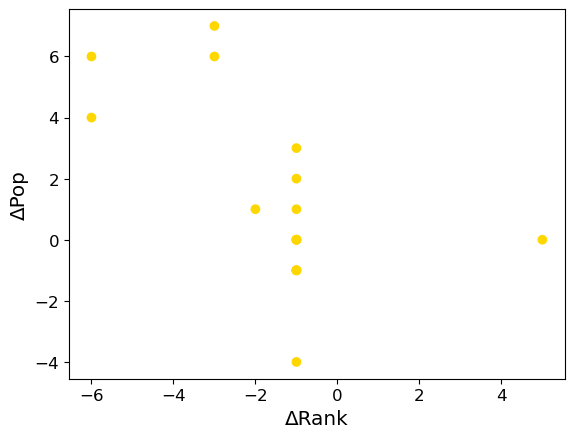

In [23]:
d_pop, d_rank, color = [], [], []
out_path = "docking_poses/DiffDock_2023/self_cross_dock/"

sd_2_tmp = sd_2.drop_duplicates(["PDB_chain_LIG", "rank"])
for i, ref_lig, lo_label in zip(sd_1.ind, sd_1.ref_lig, sd_1.lo_label):
    lig_fns = sorted(glob(f'{out_path}/index{i}/rank*_*.sdf'), key=lambda x: int(os.path.basename(x).split('_')[0].split('.')[0][4:]))
    rmsd_l, cent_dist =  get_rmsd_to_ref(ref_lig, lig_fns)
    if any([x < 2.0 for x in rmsd_l]):
        r, p = get_crossdocking_bias(lig_fns, sd_2_tmp[sd_2_tmp.ind==i], rmsd_l)
        d_pop.append(p)
        d_rank.append(r)
        color.append(lo_label)

color_list = ['gold', 'pink']
plt.scatter(d_rank, d_pop, color = [color_list[x] for x in color])
plt.xlabel(f"ΔRank")
plt.ylabel(f"ΔPop")

{1: [1, 2], 3: [3, 5, 7, 8], 4: [4], 6: [6, 9], 10: [10]}
{1: [1, 5, 8, 9, 10], 2: [2], 3: [3, 4, 7], 6: [6]}
{1: [1, 5, 8], 2: [2, 3, 7, 9], 4: [4], 6: [6], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 3, 10], 2: [2, 4, 5, 6, 7, 8, 9]}
{1: [1, 4, 6, 8, 9, 10], 2: [2, 7], 3: [3, 5]}
{1: [1], 2: [2], 3: [3, 6], 4: [4], 5: [5, 7, 8, 9, 10]}


Text(0, 0.5, 'ΔPop')

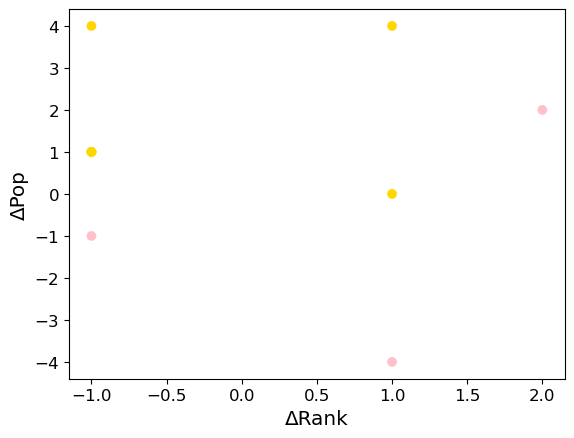

In [645]:
rms_cut = 0.5

d_pop, d_rank, color = [], [], []
out_path_LRD = "docking_poses/DiffDock_LRD/self_cross_dock/"

sd_2_tmp = sd_2.drop_duplicates(["PDB_chain_LIG", "rank"])
for i, ref_lig, lo_label in zip(sd_1.ind, sd_1.ref_lig, sd_1.lo_label):
    lig_fns = sorted(glob(f'{out_path_LRD}/index{i}/rank*.pdb'), key=lambda x: int(os.path.basename(x).split('_')[0].split('.')[0][4:]))
    rmsd_l, cent_dist =  get_rmsd_to_ref(ref_lig, lig_fns)
    if any([x < 2.0 for x in rmsd_l]):
        r, p = get_crossdocking_bias(lig_fns, sd_2_tmp[sd_2_tmp.ind==i], rmsd_l)
        d_pop.append(p)
        d_rank.append(r)
        color.append(lo_label)

color_list = ['gold', 'pink']
plt.scatter(d_rank, d_pop, color = [color_list[x] for x in color])
plt.xlabel(f"ΔRank")
plt.ylabel(f"ΔPop")

[13:54:23] Explicit valence for atom # 22 O, 3, is greater than permitted
[13:54:23] Explicit valence for atom # 22 O, 3, is greater than permitted
[13:54:23] Explicit valence for atom # 22 O, 3, is greater than permitted


skip docking_poses/DiffDock-S/self_cross_dock/1B38_A-ATP_2_1.1_2.5.pdb:1, docking_poses/DiffDock-S/self_cross_dock/1B38_A-ATP_7_1.3_1.3.pdb:4
skip docking_poses/DiffDock-S/self_cross_dock/1B38_A-ATP_1_1.4_2.5.pdb:2, docking_poses/DiffDock-S/self_cross_dock/1B38_A-ATP_7_1.3_1.3.pdb:4
skip docking_poses/DiffDock-S/self_cross_dock/1B38_A-ATP_3_1.5_2.1.pdb:3, docking_poses/DiffDock-S/self_cross_dock/1B38_A-ATP_7_1.3_1.3.pdb:4
{1: [1], 2: [2], 3: [3, 3], 4: [4], 5: [5]}
0 -1
{1: [1, 2, 3, 4, 5, 6, 7], 8: [8, 9, 10]}
4 -7
{1: [1, 5], 2: [2], 3: [3], 4: [4], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
-1 6
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5]}
except 1JST_A-ATP index 0 is out of bounds for axis 0 with size 0
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
10 -10
{1: [1, 3, 4, 5, 7, 8, 9], 2: [2, 6], 10: [10]}
5 -1
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9], 10: [10]}
8 -9
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
10 -10
{1: [1, 2], 3: [3], 4: [4, 8], 5: [5], 6: [6], 7: [7], 9: [9], 10: [10]}
-1 2
{1: [1, 2, 3, 5], 4: 

[13:54:27] Explicit valence for atom # 30 C, 5, is greater than permitted
[13:54:27] Explicit valence for atom # 30 C, 5, is greater than permitted
[13:54:27] Explicit valence for atom # 30 C, 5, is greater than permitted
[13:54:28] Explicit valence for atom # 30 C, 5, is greater than permitted
[13:54:28] Explicit valence for atom # 30 C, 5, is greater than permitted


skip docking_poses/DiffDock-S/self_cross_dock/4BCM_C-T7Z_2_0.9_4.2.pdb:2, docking_poses/DiffDock-S/self_cross_dock/4BCM_C-T7Z_5_1.1_3.7.pdb:5
skip docking_poses/DiffDock-S/self_cross_dock/4BCM_C-T7Z_2_0.9_4.2.pdb:2, docking_poses/DiffDock-S/self_cross_dock/4BCM_C-T7Z_6_0.9_3.6.pdb:6
skip docking_poses/DiffDock-S/self_cross_dock/4BCM_C-T7Z_1_0.9_4.2.pdb:1, docking_poses/DiffDock-S/self_cross_dock/4BCM_C-T7Z_7_3.6_3.6.pdb:7
skip docking_poses/DiffDock-S/self_cross_dock/4BCM_C-T7Z_2_0.9_4.2.pdb:2, docking_poses/DiffDock-S/self_cross_dock/4BCM_C-T7Z_7_3.6_3.6.pdb:7
skip docking_poses/DiffDock-S/self_cross_dock/4BCM_C-T7Z_3_0.9_4.1.pdb:3, docking_poses/DiffDock-S/self_cross_dock/4BCM_C-T7Z_7_3.6_3.6.pdb:7
skip docking_poses/DiffDock-S/self_cross_dock/4BCM_C-T7Z_4_1.3_4.1.pdb:4, docking_poses/DiffDock-S/self_cross_dock/4BCM_C-T7Z_7_3.6_3.6.pdb:7
skip docking_poses/DiffDock-S/self_cross_dock/4BCM_C-T7Z_5_1.1_3.7.pdb:5, docking_poses/DiffDock-S/self_cross_dock/4BCM_C-T7Z_7_3.6_3.6.pdb:7
skip d

[13:54:28] Explicit valence for atom # 30 C, 5, is greater than permitted
[13:54:28] Explicit valence for atom # 30 C, 5, is greater than permitted
[13:54:28] Explicit valence for atom # 30 C, 5, is greater than permitted
[13:54:28] Explicit valence for atom # 30 C, 5, is greater than permitted
[13:54:28] Explicit valence for atom # 30 C, 5, is greater than permitted
[13:54:28] Explicit valence for atom # 30 C, 5, is greater than permitted
[13:54:28] Explicit valence for atom # 30 C, 5, is greater than permitted
[13:54:28] Explicit valence for atom # 30 C, 5, is greater than permitted
[13:54:28] Explicit valence for atom # 30 C, 5, is greater than permitted
[13:54:28] Explicit valence for atom # 30 C, 5, is greater than permitted
[13:54:28] Explicit valence for atom # 30 C, 5, is greater than permitted
[13:54:28] Explicit valence for atom # 30 C, 5, is greater than permitted
[13:54:28] Explicit valence for atom # 30 C, 5, is greater than permitted
[13:54:28] Explicit valence for atom #

skip docking_poses/DiffDock-S/self_cross_dock/4BCM_C-T7Z_1_0.9_4.2.pdb:1, docking_poses/DiffDock-S/self_cross_dock/4BCM_C-T7Z_9_1.1_3.4.pdb:9
skip docking_poses/DiffDock-S/self_cross_dock/4BCM_C-T7Z_2_0.9_4.2.pdb:2, docking_poses/DiffDock-S/self_cross_dock/4BCM_C-T7Z_9_1.1_3.4.pdb:9
skip docking_poses/DiffDock-S/self_cross_dock/4BCM_C-T7Z_3_0.9_4.1.pdb:3, docking_poses/DiffDock-S/self_cross_dock/4BCM_C-T7Z_9_1.1_3.4.pdb:9
skip docking_poses/DiffDock-S/self_cross_dock/4BCM_C-T7Z_4_1.3_4.1.pdb:4, docking_poses/DiffDock-S/self_cross_dock/4BCM_C-T7Z_9_1.1_3.4.pdb:9
skip docking_poses/DiffDock-S/self_cross_dock/4BCM_C-T7Z_5_1.1_3.7.pdb:5, docking_poses/DiffDock-S/self_cross_dock/4BCM_C-T7Z_9_1.1_3.4.pdb:9
skip docking_poses/DiffDock-S/self_cross_dock/4BCM_C-T7Z_6_0.9_3.6.pdb:6, docking_poses/DiffDock-S/self_cross_dock/4BCM_C-T7Z_9_1.1_3.4.pdb:9
skip docking_poses/DiffDock-S/self_cross_dock/4BCM_C-T7Z_7_3.6_3.6.pdb:7, docking_poses/DiffDock-S/self_cross_dock/4BCM_C-T7Z_9_1.1_3.4.pdb:9
skip d

[13:54:28] Explicit valence for atom # 30 C, 5, is greater than permitted
[13:54:28] Explicit valence for atom # 30 C, 5, is greater than permitted
[13:54:28] Explicit valence for atom # 30 C, 5, is greater than permitted


{1: [1, 6, 7], 2: [2, 3], 4: [4], 5: [5], 8: [8], 9: [9], 10: [10]}
1 -1
{1: [1, 2, 3, 4, 5, 6, 7], 8: [8, 9], 10: [10]}
5 -7
{1: [1, 2], 3: [3, 4, 6], 5: [5], 7: [7, 8], 9: [9], 10: [10]}
-1 -2
{1: [1, 3, 5, 6, 7, 8, 10], 2: [2, 4], 9: [9]}
5 -1
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7, 8], 9: [9], 10: [10]}
0 -1


Text(0, 0.5, 'ΔPop')

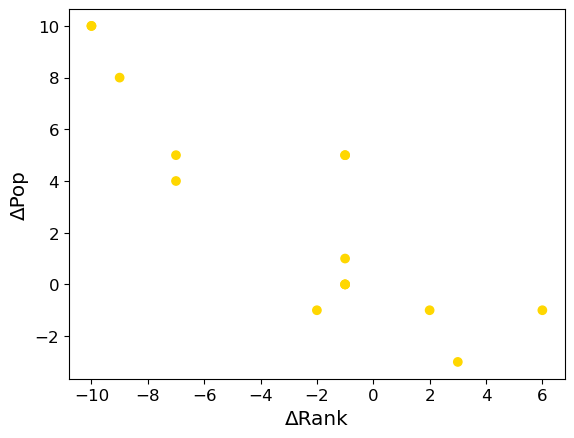

In [38]:
d_pop, d_rank, color = [], [], []
dd_S_dir = "docking_poses/DiffDock-S/self_cross_dock/"

df_S_sd_tmp = df_S_sd.drop_duplicates("name")
for name, lo_label in zip(df_S_sd_tmp.name, df_S_sd_tmp.lo_label):
    lig_fns = sorted(glob(f'{dd_S_dir}/{name}_*.pdb'), key=lambda x: -float(os.path.basename(x).strip('.pdb').split('/')[-1].split('_')[4]))
    # rmsd_l, cent_dist =  get_rmsd_to_ref(lig_fns, ref_lig )
    rmsd_l = df_S_sd[df_S_sd.name==name].RMSD.to_list()
    if any([x < 2.0 for x in rmsd_l]):
        try:
            r, p = get_crossdocking_bias(lig_fns, df_S_sd[df_S_sd.name==name], rmsd_l, mol1_type = "dd_pdb", mol2_type = "dd_pdb")
            d_pop.append(p)
            d_rank.append(r)
            color.append(lo_label)
            print(p, r)
        except Exception as e:
            print("except", name, e)
        # break

color_list = ['gold', 'pink']
plt.scatter(d_rank, d_pop, color = [color_list[x] for x in color])
plt.xlabel(f"ΔRank")
plt.ylabel(f"ΔPop")

[14:04:21] Explicit valence for atom # 17 O, 3, is greater than permitted
[14:04:21] Explicit valence for atom # 17 O, 3, is greater than permitted
[14:04:21] Explicit valence for atom # 17 O, 3, is greater than permitted
[14:04:21] Explicit valence for atom # 17 O, 3, is greater than permitted
[14:04:21] Explicit valence for atom # 17 O, 3, is greater than permitted
[14:04:21] Explicit valence for atom # 17 O, 3, is greater than permitted
[14:04:21] Explicit valence for atom # 17 O, 3, is greater than permitted
[14:04:21] Explicit valence for atom # 17 O, 3, is greater than permitted
[14:04:21] Explicit valence for atom # 17 O, 3, is greater than permitted
[14:04:21] Explicit valence for atom # 17 O, 3, is greater than permitted
[14:04:21] Explicit valence for atom # 17 O, 3, is greater than permitted
[14:04:21] Explicit valence for atom # 17 O, 3, is greater than permitted
[14:04:21] Explicit valence for atom # 17 O, 3, is greater than permitted
[14:04:21] Explicit valence for atom #

skip docking_poses/DiffDock-L/self_cross_dock/1B38_A-ATP_1_0.5_-0.1.pdb:1, docking_poses/DiffDock-L/self_cross_dock/1B38_A-ATP_4_0.6_-0.2.pdb:5
skip docking_poses/DiffDock-L/self_cross_dock/1B38_A-ATP_2_1.0_-0.2.pdb:2, docking_poses/DiffDock-L/self_cross_dock/1B38_A-ATP_4_0.6_-0.2.pdb:5
skip docking_poses/DiffDock-L/self_cross_dock/1B38_A-ATP_5_0.9_-0.2.pdb:3, docking_poses/DiffDock-L/self_cross_dock/1B38_A-ATP_4_0.6_-0.2.pdb:5
skip docking_poses/DiffDock-L/self_cross_dock/1B38_A-ATP_3_0.7_-0.2.pdb:4, docking_poses/DiffDock-L/self_cross_dock/1B38_A-ATP_4_0.6_-0.2.pdb:5
skip docking_poses/DiffDock-L/self_cross_dock/1B38_A-ATP_1_0.5_-0.1.pdb:1, docking_poses/DiffDock-L/self_cross_dock/1B38_A-ATP_7_0.7_-0.3.pdb:6
skip docking_poses/DiffDock-L/self_cross_dock/1B38_A-ATP_2_1.0_-0.2.pdb:2, docking_poses/DiffDock-L/self_cross_dock/1B38_A-ATP_7_0.7_-0.3.pdb:6
skip docking_poses/DiffDock-L/self_cross_dock/1B38_A-ATP_5_0.9_-0.2.pdb:3, docking_poses/DiffDock-L/self_cross_dock/1B38_A-ATP_7_0.7_-0.

[14:04:22] Explicit valence for atom # 17 O, 3, is greater than permitted
[14:04:22] Explicit valence for atom # 17 O, 3, is greater than permitted


{1: [1], 2: [2, 4], 3: [3, 5, 8], 6: [6], 7: [7], 9: [9], 10: [10]}
0 6
{1: [1], 2: [2, 7], 3: [3], 4: [4], 5: [5], 6: [6], 8: [8], 9: [9, 10]}
0 3
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
1 -1
{1: [1, 3, 6, 7, 8, 9, 10], 2: [2, 4, 5]}
4 -1
{1: [1, 2, 3, 4, 6, 7, 8, 9, 10], 5: [5]}
8 -4
{1: [1, 2, 3, 4, 5, 7, 10], 6: [6, 8, 9]}
4 -5
{1: [1, 2], 3: [3, 4, 5, 6, 7], 8: [8], 9: [9], 10: [10]}
3 2
{1: [1, 2, 3, 4, 5, 6], 7: [7, 8, 9, 10]}
-2 6
skip docking_poses/DiffDock-L/self_cross_dock/4BCM_C-T7Z_1_0.8_-0.2.pdb:1, docking_poses/DiffDock-L/self_cross_dock/4BCM_C-T7Z_2_1.0_-0.3.pdb:2
skip docking_poses/DiffDock-L/self_cross_dock/4BCM_C-T7Z_1_0.8_-0.2.pdb:1, docking_poses/DiffDock-L/self_cross_dock/4BCM_C-T7Z_5_1.0_-0.4.pdb:3
skip docking_poses/DiffDock-L/self_cross_dock/4BCM_C-T7Z_1_0.8_-0.2.pdb:1, docking_poses/DiffDock-L/self_cross_dock/4BCM_C-T7Z_4_1.1_-0.4.pdb:4
skip docking_poses/DiffDock-L/self_cross_dock/4BCM_C-T7Z_1_0.8_-0.2.pdb:1, docking_poses/DiffDock-L/self_cross_dock/4BCM_C-T7Z_3

[14:04:23] Explicit valence for atom # 30 C, 5, is greater than permitted
[14:04:23] Explicit valence for atom # 30 C, 5, is greater than permitted
[14:04:23] Explicit valence for atom # 30 C, 5, is greater than permitted
[14:04:23] Explicit valence for atom # 30 C, 5, is greater than permitted
[14:04:23] Explicit valence for atom # 30 C, 5, is greater than permitted
[14:04:23] Explicit valence for atom # 30 C, 5, is greater than permitted
[14:04:23] Explicit valence for atom # 30 C, 5, is greater than permitted
[14:04:23] Explicit valence for atom # 30 C, 5, is greater than permitted
[14:04:23] Explicit valence for atom # 30 C, 5, is greater than permitted


skip docking_poses/DiffDock-L/self_cross_dock/4BCM_C-T7Z_1_0.8_-0.2.pdb:1, docking_poses/DiffDock-L/self_cross_dock/4BCM_C-T7Z_9_3.2_-0.8.pdb:8
skip docking_poses/DiffDock-L/self_cross_dock/4BCM_C-T7Z_1_0.8_-0.2.pdb:1, docking_poses/DiffDock-L/self_cross_dock/4BCM_C-T7Z_8_3.1_-0.8.pdb:9
skip docking_poses/DiffDock-L/self_cross_dock/4BCM_C-T7Z_1_0.8_-0.2.pdb:1, docking_poses/DiffDock-L/self_cross_dock/4BCM_C-T7Z_10_3.1_-0.9.pdb:10
{1: [1], 2: [2, 7], 3: [3, 6], 4: [4, 5], 8: [8, 9, 10]}
-1 -1
{1: [1, 4, 9], 2: [2, 5, 6, 7, 8, 10], 3: [3]}
-3 -1
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
1 -1
{1: [1, 2, 3, 4, 5, 6, 7, 9], 8: [8], 10: [10]}
7 -7
{1: [1, 5], 2: [2, 3, 6], 4: [4], 7: [7, 8, 9, 10]}
-1 -1
{1: [1, 9], 2: [2, 4, 5, 7, 10], 3: [3], 6: [6], 8: [8]}
-3 -1


Text(0, 0.5, 'ΔPop')

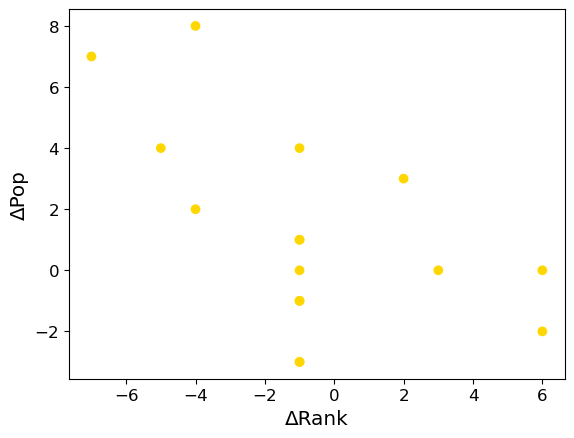

In [ ]:
rms_cut = 0.5

d_pop, d_rank, color = [], [], []
dd_S_dir = "docking_poses/DiffDock-L/self_cross_dock/"

df_S_sd_tmp = df_S_sd.drop_duplicates("name")
for name, lo_label in zip(df_S_sd_tmp.name, df_S_sd_tmp.lo_label):
    lig_fns = sorted(glob(f'{dd_S_dir}/{name}_*.pdb'), key=lambda x: -float(os.path.basename(x).strip('.pdb').split('/')[-1].split('_')[4]))
    # rmsd_l, cent_dist =  get_rmsd_to_ref(lig_fns, ref_lig )
    rmsd_l = df_S_sd[df_S_sd.name==name].RMSD.to_list()
    if any([x < 2.0 for x in rmsd_l]):
        try:
            r, p = get_crossdocking_bias(lig_fns, df_S_sd[df_S_sd.name==name], rmsd_l,  mol1_type = "dd_pdb", mol2_type = "dd_pdb")
            d_pop.append(p)
            d_rank.append(r)
            color.append(lo_label)
            print(p, r)
        except Exception as e:
            print("except", name, e)
        # break

color_list = ['gold', 'pink']
plt.scatter(d_rank, d_pop, color = [color_list[x] for x in color])
plt.xlabel(f"ΔRank")
plt.ylabel(f"ΔPop")

{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
0 4
{1: [1], 2: [2, 4, 6], 3: [3], 5: [5, 7], 8: [8], 9: [9, 10]}
2 1
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
0 -1
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
1 -1
{1: [1, 2, 3, 4, 5, 8, 9, 10], 6: [6], 7: [7]}
7 -5
{1: [1, 2, 4, 5, 6, 8, 9, 10], 3: [3], 7: [7]}
7 -2
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
1 -1
{1: [1, 2, 3, 4, 9], 5: [5, 6, 7, 8, 10]}
0 -4
{1: [1, 2], 3: [3, 5, 7, 8, 9, 10], 4: [4], 6: [6]}
-4 -2
{1: [1], 2: [2, 4], 3: [3], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
-1 -1
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5, 8], 6: [6], 7: [7], 9: [9], 10: [10]}
0 -1
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
1 -1
{1: [1], 2: [2, 4], 3: [3], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
0 5
{1: [1, 2, 4, 5, 6, 8], 3: [3], 7: [7, 9], 10: [10]}
5 -2
{1: [1], 2: [2], 3: [3, 10], 4: [4], 5: [5, 6], 7: [7], 8: [8], 9: [9]}
0 -1


Text(0, 0.5, 'ΔPop')

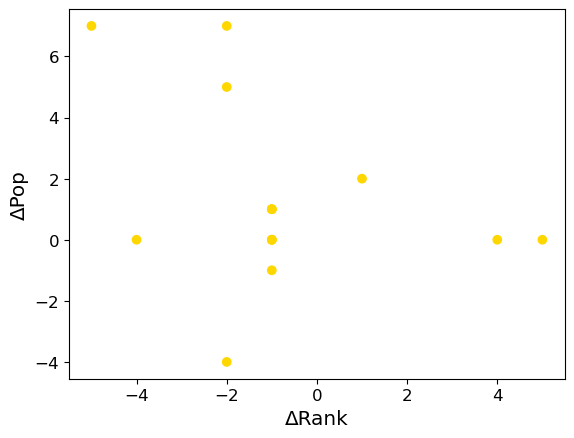

In [670]:
rms_cut = 0.5

d_pop, d_rank, color = [], [], []
dd_dyn_dir = "./docking_poses/DynBind/self_cross_dock/"

df_dyn_tmp = df_dyn_sd.drop_duplicates("PDB_chain_LIG")
for pdb_chain, lig, lo_label in zip(df_dyn_tmp.PDB_chain, df_dyn_tmp.LIG, df_dyn_tmp.lo_label):
    lig_fns = sorted(glob(f'{dd_dyn_dir}/{pdb_chain}-{lig}/rank*_*.sdf'), key=lambda x: int(os.path.basename(x).strip('.sdf').split('/')[-1].split('_')[0].strip("rank")))
    # rmsd_l, cent_dist =  get_rmsd_to_ref(lig_fns, ref_lig )
    name = f"{pdb_chain}_{lig}"
    rmsd_l = df_dyn_sd[df_dyn_sd.PDB_chain_LIG==name].RMSD.to_list()
    if any([x < 2.0 for x in rmsd_l]):
        try:
            r, p = get_crossdocking_bias(lig_fns, df_dyn_sd[df_dyn_sd.PDB_chain_LIG==name], rmsd_l)
            d_pop.append(p)
            d_rank.append(r)
            color.append(lo_label)
            print(p, r)
        except Exception as e:
            print("except", name, e)
        # break

color_list = ['gold', 'pink']
plt.scatter(d_rank, d_pop, color = [color_list[x] for x in color])
plt.xlabel(f"ΔRank")
plt.ylabel(f"ΔPop")

Text(0, 0.5, 'ΔPop')

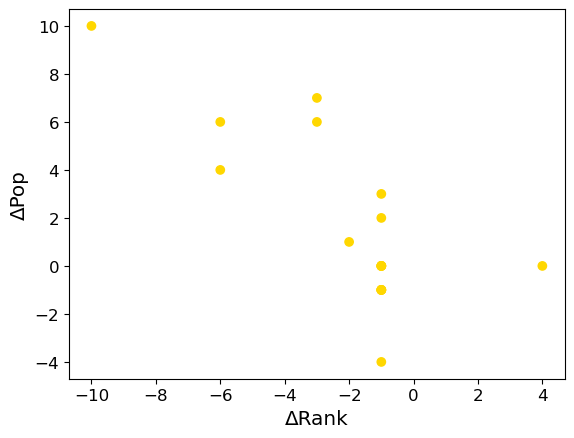

In [232]:
rms_cut = 0.5

d_pop, d_rank, color = [], [], []

sd_2_tmp = sd_2.drop_duplicates(["PDB_chain_LIG", "rank"])
for i, ref_lig, lo_label in zip(sd_1.ind, sd_1.ref_lig, sd_1.lo_label):
    # rmsd_l, cent_dist = [], []
    lig_fns = sorted(glob(f'{out_path}/index{i}/rank*_*.sdf'), key=lambda x: int(os.path.basename(x).split('_')[0].split('.')[0][4:]))
    rmsd_l, cent_dist =  get_rmsd_to_ref(lig_fns, ref_lig )
    # lig_fns = sorted(glob(f'{out_path}/index{i}/rank*_*.sdf'), key=lambda x: int(os.path.basename(x).split('_')[0].split('.')[0][4:]))
    # for lig, conf, rank in zip(lig_fns, sd_2[sd_2.ind==i].confidence, sd_2[sd_2.ind==i]['rank']):
    #     RMSD_ref, cent_dist_ref = sRMSD(ref_lig, lig)
    #     rmsd_l.append(RMSD_ref)

    if any([x < 2.0 for x in rmsd_l]):
        # break
        r, p = get_crossdocking_bias(lig_fns, sd_2_tmp[sd_2_tmp.ind==i])
        d_pop.append(p)
        d_rank.append(r)
        color.append(lo_label)

        # seed_rank = 1
        # cluster_dict = {1: [1]}
        # sd_2_tmp = sd_2.drop_duplicates(["PDB_chain_LIG", "rank"])
        # for lig, conf, rank in zip(lig_fns[1:], sd_2_tmp[sd_2_tmp.ind==i].confidence[1:], \
        #                         sd_2_tmp[sd_2_tmp.ind==i]['rank'][1:]):
        #     found = False
        #     for rank_ref in cluster_dict.keys():
        #         seed = lig_fns[rank_ref-1]
        #         cluster_RMSD, cent_dist = sRMSD(seed, lig)
        #         # print(rank_ref, rank, cluster_RMSD)
        #         if cluster_RMSD < rms_cut:
        #             cluster_dict[rank_ref].append(rank)
        #             found = True
        #             break
        #     if not found:
        #         cluster_dict[rank] = [rank]
            
        # # cluster_dict
        # if len(cluster_dict) > 1:
        #     cluster_reps = list(cluster_dict.keys())
        #     best_pose_ind = np.where(np.asarray([rmsd_l[rank-1] < 2.0 for rank in cluster_reps]))[0][0]

        #     # best_pose_ind = np.where([any([rmsd_l[r-1] < 2.0 for r in rank]) for key,rank in cluster_dict.items()])[0][0]
        #     best_fp = np.delete(cluster_reps, best_pose_ind)[0]
        #     d_pop.append(len(cluster_dict[best_pose_ind+1]) - len(cluster_dict[best_fp]))
        #     d_rank.append(best_pose_ind+1-best_fp)
        #     color.append(lo_label)
        #     print(len(cluster_dict[best_pose_ind+1]) - len(cluster_dict[best_fp]), best_pose_ind+1-best_fp)
        # else:
        #     d_rank.append(-10)
        #     d_pop.append(10)
        #     color.append(lo_label)

color_list = ['gold', 'pink']
plt.scatter(d_rank, d_pop, color = [color_list[x] for x in color])
plt.xlabel(f"ΔRank")
plt.ylabel(f"ΔPop")


In [11]:
# ## get DiffDock and DiffDock-Lin_F9 LRD data
# rmsd_l, cent_dist_l = [], [] 
# rmsd_l_LRD, cent_dist_l_LRD = [], []

# out_path = "docking_poses/DiffDock_2023/self_cross_dock/"
# out_path_LRD = "docking_poses/DiffDock_LRD/self_cross_dock/"

# for i, ref_lig in zip(sd_1.ind, sd_1.ref_lig):
#     lig_fns = sorted(glob(f'{out_path}/index{i}/rank*_*.sdf'), key=lambda x: int(os.path.basename(x).split('_')[0].split('.')[0][4:]))
#     for lig in lig_fns:
#         RMSD, cent_dist = sRMSD(ref_lig, lig)
#         rmsd_l.append(RMSD)
#         cent_dist_l.append(cent_dist)

#     lig_fns = sorted(glob(f'{out_path_LRD}/index{i}/rank*.pdb'), key=lambda x: int(os.path.basename(x).split('_')[0].split('.')[0][4:]))
#     for lig in lig_fns:
#         RMSD, cent_dist = sRMSD(ref_lig, lig)
#         rmsd_l_LRD.append(RMSD)
#         cent_dist_l_LRD.append(cent_dist)

# sd_2["RMSD"] = rmsd_l
# sd_2["cent_dist"] = cent_dist_l
# sd_2_LRD["RMSD"] = rmsd_l_LRD
# sd_2_LRD["cent_dist"] = cent_dist_l_LRD

## crossdocking results

In [20]:
pdb_path = "docking_poses/receptor/CDK2_fastH/"
lig_path = "datafiles/lig_pdb_all/"
all_model_path = "docking_poses/receptor/CDK2_allmodel"
cdk2_all_model = ['1FIN_A', '1FIN_C', '1FVV_A', '1FVV_C', '1JST_A', '1JST_C', '1PF8_A', '1VYW_A', '1VYW_C', '1YKR_A', '2B54_A', '2BKZ_A', '2BPM_A', '2BPM_C', '2C4G_C', '2EXM_A', '2G9X_A', '2WIH_A', '2WIH_C', '2WPA_A', '2WPA_C', '2WXV_A', '2WXV_C', '3DDP_C', '3F5X_C', '3PXF_A', '3PXZ_A', '3PY1_A', '4BCO_A', '4BCP_A', '4CFV_A', '4CFW_A', '4CFX_A', '4CFX_C', '4EON_A', '4EZ7_A', '4FX3_A', '4FX3_C', '4GCJ_A', '4KD1_A', '5CYI_A', '5IF1_A', '6P3W_A', '6YL6_A', '7E34_A', '7RWF_A']
dataset_dir = "datafiles/crd_dataset/"

unique_lig = allo_crd.LIG.unique()
unique_PDB_chain = allo_crd.PDB_fn.unique()

lig_dir_all = []
for lig in unique_lig:
    # tup: (pdb_name, pdb_chain, lig_name, lig_chain, pdb_lig_dir)
    # will need to change this when aligning peptide complexes
    lig_dir_all.extend([(os.path.basename(ldir)[:6], os.path.basename(ldir)[5], \
        os.path.basename(ldir)[7:], os.path.basename(ldir)[5], ldir) for ldir in glob(f"{dataset_dir}/*{lig}*")])
        
# load pdb and ligand structures into data object
samp_pdb_dict = load_struct([(glob(f"{lig_dir}/{pdb}.pdb")[0], pdb_chain, f"{pdb}_{lig}") for (pdb, pdb_chain, lig, _, lig_dir) in lig_dir_all])
samp_lig_dict = load_struct([(glob(f"{lig_dir}/{pdb}_{lig}.pdb")[0], lig_chain, f"{pdb}_{lig}") for (pdb, _, lig, lig_chain, lig_dir) in lig_dir_all])

modeller_pdb_list = [(f'{all_model_path}/{pdb[:6]}.pdb' if pdb in cdk2_all_model else f'{pdb_path}/{pdb}.pdb', pdb[5], pdb) for pdb in unique_PDB_chain]
ref_pdb_dict = load_struct(modeller_pdb_list)

In [21]:
from copy import deepcopy 

## for each structure, align all other structures and output the aligned ligand with a string
align_ref = {} 
for ref, ref_dict in ref_pdb_dict.items():
    t_ref = deepcopy(ref_dict['struct'])
    for samp, samp_dict in samp_pdb_dict.items():
        lig = samp.split('_')[-2]
        res_num = samp.split('_')[-1]
        samp_pdb = samp[:6]
        t_samp = deepcopy(samp_dict['struct'])
        s_lig = deepcopy(samp_lig_dict[samp]['struct'])
        out_str = align_lig(t_ref, t_samp, s_lig, samp_lig_dict[samp]['chain'], range(1,299))

        # we are aligning the samp structure to ref...
        # sometimes we will have multiple complexes with the same ligand
        # add the outputted ligand to the complex
        try:
            align_ref[f"{ref}-{lig}"].update({f"{samp}": out_str})
        except KeyError:
            # dict_x[key] = [value]
            align_ref[f"{ref}-{lig}"] = {f"{samp}": out_str}

In [22]:
allo_crd = allo_crd.loc[allo_crd.PDB_chain.isin(ro_ts_pca.PDB_chain)].reset_index(drop=True)

allo_crd_1 = allo_crd[~allo_crd.PDB_chain_LIG.isin(sd_cdk2.PDB_chain_LIG)]
allo_crd_2 = pd.concat([allo_crd_1[['ind','protein_path', 'ligand', 'PDB_fn', 'PDB', 'PDB_chain', 'LIG','PDB_chain_LIG', 'ro_label', 'lo_label', "lig_lr_label"]]]*10, ignore_index=True).sort_values(["ind"])
allo_crd_2['rank'] = np.tile(np.arange(1, 11), len(allo_crd_1))
allo_crd_2 = allo_crd_2.sort_values(["ind", "rank"], ascending=[True, True]).reset_index(drop=True)
allo_crd_2["confidence"] = dd_conf[allo_crd_1["ind"],].flatten()
allo_crd_2_LRD = allo_crd_2.copy()

In [23]:
def get_rmsd_to_ref_crd(align_dict, lig_fns, mol1_type="out_str", mol2_type="fn"):
    rmsd_l, cent_dist = [], []
    for lig in lig_fns:
        # print(ref_lig, lig)
        tmp_rmsd, tmp_cent_dist = [], []
        for res_num, out_str in align_dict.items():
            RMSD_ref, cent_dist_ref = sRMSD(out_str, lig, mol1_type = mol1_type, mol2_type = mol2_type)
            tmp_cent_dist.append(cent_dist_ref)
            tmp_rmsd.append(RMSD_ref)
        rmsd_l.append(min(tmp_rmsd))
        cent_dist.append(min(tmp_cent_dist))
    return (rmsd_l, cent_dist)

# allosteric scatter plot

In [79]:
cross_dock_allo_results = {
    "vina": {"d_pop": [], "d_rank": []},
    "lin_f9": {"d_pop": [], "d_rank": []},
    "lin_f9_1": {"d_pop": [], "d_rank": []},
    "diffdock": {"d_pop": [], "d_rank": []},
    "diffdock-s": {"d_pop": [], "d_rank": []},
    "diffdock-l": {"d_pop": [], "d_rank": []},
    "dynamicbind": {"d_pop": [], "d_rank": []},
    "diffdock+lrd": {"d_pop": [], "d_rank": []}
}

In [134]:
cross_dock_allo_results["lin_f9"] = {"d_pop": [], "d_rank": []}

In [114]:
vina_path = "docking_poses/vina/self_cross_dock/"

for _, row in allo_crd_1[(allo_crd_1.lig_lr_label == (1,1)) & (allo_crd_1.ro_label == 3)]\
                        .drop_duplicates("PDB_chain_LIG").iterrows():
    i = row.ind
    pdb_fn = row.PDB_fn
    lig = row.LIG
    lo_label = row.lo_label
    vina_out_str = [read_vina(fn) for fn in 
                sorted(glob(f'{vina_path}/index{i}/*_*.pdbqt'),
                        key=lambda x: int(os.path.basename(x).strip('.pdbqt').split('_')[-1]))]
    vina_sel = vina[(vina.ind==i) & (vina['rank'] <= 10)]
    lig_fns = ["".join(vina_out_str[id-1][rank-1]) \
               for id, rank in zip(vina_sel.conf_id, vina_sel.conf_rank)]
    rmsd_l, cent_dist =  get_rmsd_to_ref_crd(align_ref[f'{pdb_fn}-{lig}'], \
                                             lig_fns, mol2_type="pdbqt_out_str")

    if any([x < 5.0 for x in cent_dist]):
        r, p = get_crossdocking_bias(lig_fns, vina_sel, cent_dist, mol1_type="pdbqt_out_str", mol2_type="pdbqt_out_str", lt = 5.0)
        cross_dock_allo_results['vina']['d_pop'].append(p)
        cross_dock_allo_results['vina']['d_rank'].append(r)


{1: [1, 3, 7], 2: [2, 5, 9], 4: [4, 6, 10], 8: [8]}
{1: [1, 4, 8], 2: [2, 3, 7], 5: [5], 6: [6, 9, 10]}
{1: [1, 2, 4], 3: [3], 5: [5, 6], 7: [7], 8: [8, 10], 9: [9]}
{1: [1, 2, 3, 4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 9], 2: [2, 3], 4: [4, 6], 5: [5, 7], 8: [8], 10: [10]}
{1: [1, 9], 2: [2, 4, 8], 3: [3], 5: [5], 6: [6], 7: [7], 10: [10]}
{1: [1, 3, 9], 2: [2, 6], 4: [4], 5: [5], 7: [7], 8: [8], 10: [10]}
{1: [1, 5, 6], 2: [2, 3, 4], 7: [7], 8: [8, 9], 10: [10]}
{1: [1, 4, 6], 2: [2, 7], 3: [3, 5, 9], 8: [8], 10: [10]}
{1: [1, 5], 2: [2], 3: [3], 4: [4, 6], 7: [7, 8, 10], 9: [9]}
{1: [1, 2, 3, 4], 5: [5], 6: [6, 8], 7: [7, 9], 8: [8], 10: [10]}
{1: [1, 2, 7], 3: [3, 10], 4: [4, 8], 5: [5], 6: [6], 9: [9]}
{1: [1, 2, 4, 7], 3: [3, 9], 5: [5, 10], 6: [6], 8: [8]}
{1: [1, 2, 3, 5, 7, 10], 4: [4], 6: [6, 9], 8: [8]}
{1: [1, 5, 6, 7], 2: [2, 4], 3: [3, 8], 9: [9], 10: [10]}
{1: [1, 2, 6, 7], 3: [3, 8], 4: [4, 5], 9: [9, 10]}


In [135]:
lin_f9_path = "docking_poses/lin_f9/self_cross_dock/"

for _, row in allo_crd_1[(allo_crd_1.lig_lr_label == (1,1)) & (allo_crd_1.ro_label == 1)]\
                        .drop_duplicates("PDB_chain_LIG").iterrows():
    i = row.ind
    pdb_fn = row.PDB_fn
    lig = row.LIG
    lo_label = row.lo_label
    lin_f9_out_str = [read_vina(fn) for fn in 
                      sorted(glob(f'{lin_f9_path}/index{i}/*_*.pdbqt'),
                             key=lambda x: int(os.path.basename(x).strip('.pdbqt').split('_')[-1]))]
    linf9_sel = linf9[(linf9.ind==i) & (linf9['rank'] <= 10)]
    lig_fns = ["".join(lin_f9_out_str[id-1][rank-1]) for id, rank in zip(linf9_sel.conf_id, linf9_sel.conf_rank)]
    rmsd_l, cent_dist =  get_rmsd_to_ref_crd(align_ref[f'{pdb_fn}-{lig}'], lig_fns, mol2_type="pdbqt_out_str")
    
    if any([x < 5.0 for x in cent_dist]):
        r, p = get_crossdocking_bias(lig_fns, linf9_sel, cent_dist, mol1_type="pdbqt_out_str", mol2_type="pdbqt_out_str", lt = 5.0)
        cross_dock_allo_results['lin_f9_1']['d_pop'].append(p)
        cross_dock_allo_results['lin_f9_1']['d_rank'].append(r)

{1: [1], 2: [2, 4, 8], 3: [3], 5: [5, 6], 7: [7], 9: [9], 10: [10]}
1 2
{1: [1, 2, 5, 7, 8], 3: [3, 4, 6], 9: [9], 10: [10]}
-2 2
{1: [1, 2, 6], 3: [3, 4, 9], 5: [5, 8], 7: [7], 10: [10]}
2 0
{1: [1, 4, 9], 2: [2], 3: [3, 6, 8], 5: [5, 7, 10]}
-1 2
{1: [1, 2, 3, 4, 5], 6: [6, 8], 7: [7, 9], 10: [10]}
6 -3


In [136]:
lin_f9_path = "docking_poses/lin_f9/self_cross_dock/"

for _, row in allo_crd_1[(allo_crd_1.lig_lr_label == (1,1)) & (allo_crd_1.ro_label == 3)]\
                        .drop_duplicates("PDB_chain_LIG").iterrows():
    i = row.ind
    pdb_fn = row.PDB_fn
    lig = row.LIG
    lo_label = row.lo_label
    lin_f9_out_str = [read_vina(fn) for fn in 
                      sorted(glob(f'{lin_f9_path}/index{i}/*_*.pdbqt'),
                             key=lambda x: int(os.path.basename(x).strip('.pdbqt').split('_')[-1]))]
    linf9_sel = linf9[(linf9.ind==i) & (linf9['rank'] <= 10)]
    lig_fns = ["".join(lin_f9_out_str[id-1][rank-1]) for id, rank in zip(linf9_sel.conf_id, linf9_sel.conf_rank)]
    rmsd_l, cent_dist =  get_rmsd_to_ref_crd(align_ref[f'{pdb_fn}-{lig}'], lig_fns, mol2_type="pdbqt_out_str")
    
    if any([x < 5.0 for x in cent_dist]):
        r, p = get_crossdocking_bias(lig_fns, linf9_sel, cent_dist, mol1_type="pdbqt_out_str", mol2_type="pdbqt_out_str", lt = 5.0)
        cross_dock_allo_results['lin_f9']['d_pop'].append(p)
        cross_dock_allo_results['lin_f9']['d_rank'].append(r)

{1: [1, 2, 3], 4: [4, 5, 6], 7: [7, 9], 8: [8], 10: [10]}
{1: [1, 2, 3], 4: [4, 5, 6], 7: [7, 8], 9: [9], 10: [10]}
{1: [1, 2, 3], 4: [4], 5: [5, 10], 6: [6, 7], 8: [8, 9]}


In [117]:
d_pop, d_rank, color = [], [], []
dd_path = "docking_poses/DiffDock_2023/self_cross_dock/"

for _, row in allo_crd_1[(allo_crd_1.lig_lr_label == (1,1)) & (allo_crd_1.ro_label == 3)]\
                        .drop_duplicates("PDB_chain_LIG").iterrows():
    i = row.ind
    pdb_fn = row.PDB_fn
    lig = row.LIG
    lo_label = row.lo_label

    lig_fns = sorted(glob(f'{dd_path}/index{i}/rank*_*.sdf'), \
                     key=lambda x: int(os.path.basename(x).split('_')[0].split('.')[0][4:]))
    
    rmsd_l, cent_dist =  get_rmsd_to_ref_crd(align_ref[f'{pdb_fn}-{lig}'], \
                                             lig_fns, mol2_type="fn")
    
    if any([x < 5.0 for x in cent_dist]):
        print(i)
        r, p = get_crossdocking_bias(lig_fns, allo_crd_2[allo_crd_2.ind==i], cent_dist, lt=5.0)
        cross_dock_allo_results['diffdock']['d_pop'].append(p)
        cross_dock_allo_results['diffdock']['d_rank'].append(r)


39
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
94
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
178
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}


In [118]:
d_pop, d_rank, color = [], [], []
ddL_path = "./docking_poses/DiffDock-L/self_cross_dock/"

df_L = df_L.loc[df_L.PDB_chain.isin(ro_ts_pca.PDB_chain)].reset_index(drop=True)
df_L_crd = df_L[~df_L.PDB_chain_LIG.isin(sd_cdk2.PDB_chain_LIG)].drop_duplicates(["ind", "rank"])
df_L_sel = df_L_crd[(df_L_crd.lig_lr_label == (1,1)) & (df_L_crd.ro_label == 3)]

for name, lr_label in zip(df_L_sel.drop_duplicates(["ind", "PDB_chain_LIG"]).name,\
                          df_L_sel.drop_duplicates(["ind", "PDB_chain_LIG"]).lig_lr_label):
    lig_fns = sorted(glob(f'{ddL_path}/{name}_*.pdb'), \
                     key=lambda x: -float(os.path.basename(x).strip('.pdb').split('/')[-1].split('_')[4]))
    cent_dist = df_L_sel[df_L_sel.name==name].cent_dist.to_list()

    if any([x < 5.0 for x in cent_dist]):
        r, p = get_crossdocking_bias(lig_fns, df_L_sel[df_L_sel.name==name], cent_dist, lt=5, mol1_type = "dd_pdb", mol2_type = "dd_pdb")
        cross_dock_allo_results['diffdock-l']['d_pop'].append(p)
        cross_dock_allo_results['diffdock-l']['d_rank'].append(r)

{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}


In [119]:
ddlrd_path = "docking_poses/DiffDock_LRD/self_cross_dock/"

for _, row in allo_crd_1[(allo_crd_1.lig_lr_label == (1,1)) & (allo_crd_1.ro_label == 3)]\
                        .drop_duplicates("PDB_chain_LIG").iterrows():
    i = row.ind
    pdb_fn = row.PDB_fn
    lig = row.LIG
    lo_label = row.lo_label

    lig_fns = sorted(glob(f'{ddlrd_path}/index{i}/rank*.pdb'), \
                     key=lambda x: int(os.path.basename(x).split('.')[0].strip('rank')))
    
    rmsd_l, cent_dist =  get_rmsd_to_ref_crd(align_ref[f'{pdb_fn}-{lig}'], \
                                             lig_fns, mol2_type="fn")
    
    if any([x < 5.0 for x in cent_dist]):
        r, p = get_crossdocking_bias(lig_fns, allo_crd_2[allo_crd_2.ind==i], cent_dist, lt=5.0)
        cross_dock_allo_results['diffdock+lrd']['d_pop'].append(p)
        cross_dock_allo_results['diffdock+lrd']['d_rank'].append(r)


{1: [1, 2, 8], 3: [3], 4: [4], 5: [5, 9], 6: [6, 7], 10: [10]}
{1: [1, 2, 9], 3: [3], 4: [4, 10], 5: [5], 6: [6], 7: [7, 8]}
{1: [1, 5, 10], 2: [2, 3, 6], 4: [4, 8, 9], 7: [7]}
{1: [1, 3], 2: [2, 7, 9], 4: [4], 5: [5, 8], 6: [6], 10: [10]}
{1: [1, 4, 6, 7], 2: [2, 3], 5: [5], 8: [8], 9: [9], 10: [10]}
{1: [1, 3], 2: [2, 4, 6, 7, 10], 5: [5], 8: [8], 9: [9]}
{1: [1, 10], 2: [2], 3: [3, 7], 4: [4], 5: [5], 6: [6], 8: [8], 9: [9]}
{1: [1, 2, 4, 7, 8, 9, 10], 3: [3], 5: [5, 6]}
{1: [1], 2: [2], 3: [3], 4: [4, 7], 5: [5], 6: [6, 9], 8: [8], 10: [10]}
{1: [1, 2, 8], 3: [3], 4: [4, 10], 5: [5], 6: [6], 7: [7], 9: [9]}
{1: [1, 2, 4], 3: [3, 5], 6: [6, 8], 7: [7], 9: [9], 10: [10]}
{1: [1, 6], 2: [2, 3, 5, 8, 10], 4: [4, 7, 9]}
{1: [1, 2, 3, 4, 6, 7, 8, 9, 10], 5: [5]}
{1: [1], 2: [2, 8, 10], 3: [3], 4: [4, 6, 9], 5: [5], 7: [7]}
{1: [1, 2, 3, 4, 10], 5: [5], 6: [6, 7], 8: [8], 9: [9]}
{1: [1, 3, 4, 6, 7, 9], 2: [2], 5: [5, 10], 8: [8]}
{1: [1], 2: [2, 10], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7

<Figure size 500x500 with 0 Axes>

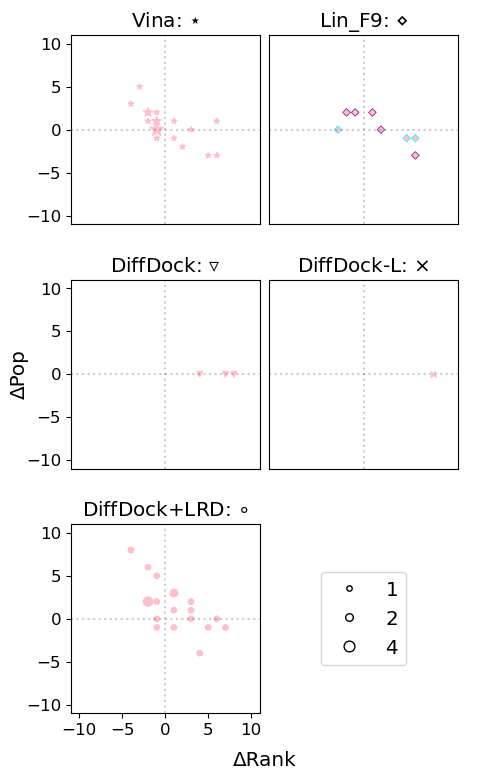

In [173]:
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(5,5))

marker_dict = {
    "vina" : {"color" : "pink", "marker" : "*"},
    "lin_f9" : {"color" : "pink", "marker" : "D", "edgecolors":"cyan", "linewidths": 0.5},
    "lin_f9_1" : {"color" : "pink", "marker" : "D", "edgecolors":"purple", "linewidths": 0.5},
    "diffdock" : {"color" : "pink", "marker" : "v",}, #"markeredgecolor":"black"},
    "diffdock-l" : {"color" : "pink", "marker" : "x",}, # "markeredgecolor":"black"},
    "diffdock+lrd" : {"color" : "pink", "marker" : "o"},
}
title_dict = {
    "vina" : r"Vina: $\star$",
    "lin_f9" : r"Lin_F9: $\diamond$",
    "diffdock" : r"DiffDock: $\triangledown$", #"markeredgecolor":"black"},
    "diffdock-l" : r"DiffDock-L: $\times$", # "markeredgecolor":"black"},
    "diffdock+lrd" : r"DiffDock+LRD: $\circ$",
}
def set_none(ax):
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
def set_plot(ax, title):
    ax.set_xlim(-11,11)
    ax.set_ylim(-11,11)
    ax.set_xticks(range(-10,11,5))
    ax.set_yticks(range(-10,11,5))

    ax.axhline(y=0, color='k', linestyle=':', alpha=0.2)
    ax.axvline(x=0, color='k', linestyle=':', alpha=0.2)
    ax.set_title(title)

fig = plt.figure(figsize=(5,9))
# fig.set_size_inches(3.25,3.25*9/5)

ax = fig.add_subplot(111) 
ax.set_xlabel(f"ΔRank")
ax.set_ylabel(f"ΔPop")

set_none(ax)
axs = fig.subplots(3,2, sharey=True, sharex=True,subplot_kw={'aspect': 1},)
set_none(axs[2][1])

def set_scatter(ax, d_rank, d_pop, **marker_kwargs):
    counts,ybins,xbins = np.histogram2d(d_rank, d_pop,\
                                    bins=(np.arange(-10.5,11.5,1), np.arange(-10.5,11.5,1)))
    xcenters = (xbins[:-1] + xbins[1:]) / 2
    ycenters = (ybins[:-1] + ybins[1:]) / 2
    X, Y = np.meshgrid(xcenters, ycenters)

    x_points = X.flatten()
    y_points = Y.flatten()
    z_values = counts.T.flatten()

    nonzero = z_values > 0
    x_points = x_points[nonzero]
    y_points = y_points[nonzero]
    z_values = z_values[nonzero]

    ax.scatter(x_points, y_points, s=z_values * 15, \
                alpha=1, **marker_kwargs)

for key, results_dict, ax_tup in zip(
                          title_dict.keys(),
                          [cross_dock_allo_results[m] for m in title_dict.keys()], 
                          [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]):
    if ax_tup[1] == 1:
         axs[ax_tup[0]][ax_tup[1]].tick_params(labelcolor='w', left=False)
    if (ax_tup[0] == 0) or (ax_tup[0] == 1):
         axs[ax_tup[0]][ax_tup[1]].tick_params(bottom=False)
    set_plot(axs[ax_tup[0]][ax_tup[1]], title_dict[key])

    set_scatter(axs[ax_tup[0]][ax_tup[1]], np.asarray(results_dict["d_rank"]), \
                np.asarray(results_dict["d_pop"]), **marker_dict[key])

set_scatter(axs[0][1], np.asarray(cross_dock_allo_results["lin_f9_1"]["d_rank"]), \
            np.asarray(cross_dock_allo_results["lin_f9_1"]["d_pop"]), **marker_dict["lin_f9_1"])

legend_sizes = [1, 2, 4]  # Example histogram counts
legends_for_size = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='white', 
           markersize=np.sqrt(size * 15), markeredgecolor='k') 
    for size in legend_sizes
]
# legend_markers = [
#     Line2D([0], [0], marker=marker, color='w', markerfacecolor='white', 
#            markersize=6, markeredgecolor='k') 
#     for marker in ["*", "d", "v", "x", "o"]
# ]

lgd = axs[2][1].legend(
    legends_for_size, 
    [f"{size}" for size in legend_sizes],
    loc="center")

plt.subplots_adjust(wspace = 0.05)
# plt.margins(0,0)
plt.savefig("/Users/ericchen/Desktop/CDK2-Manuscript/figures/dPop_v_dRank.png", dpi=600)
# plt.tight_layout(pad=0, w_pad=0.1, h_pad=0)

In [739]:
out_path = "docking_poses/vina/self_cross_dock/"
d_pop, d_rank, color = [], [], []

# for _, row in allo_crd_1.iterrows():
for _, row in allo_crd_1.iterrows():
    i = row.ind
    pdb_fn = row.PDB_fn
    lig = row.LIG
    lo_label = row.lo_label
    vina_out_str = [read_vina(fn) for fn in 
                    sorted(glob(f'{out_path}/index{i}/*_*.pdbqt'),
                           key=lambda x: int(os.path.basename(x).strip('.pdbqt').split('_')[-1]))]
    vina_sel = vina[vina.ind==i]
    lig_fns = ["".join(vina_out_str[id-1][rank-1]) for id, rank in zip(vina_sel.conf_id, vina_sel.conf_rank)]
    rmsd_l, cent_dist =  get_rmsd_to_ref_crd(align_ref[f'{pdb_fn}-{lig}'], lig_fns, mol2_type="pdbqt_out_str")

    # break
    if any([x < 5.0 for x in cent_dist]):
        r, p = get_crossdocking_bias(lig_fns, vina_sel, cent_dist, mol1_type="pdbqt_out_str", mol2_type="pdbqt_out_str", lt = 5.0)
        d_pop.append(p)
        d_rank.append(r)
        color.append(lo_label)

color_list = ['gold', 'pink']
plt.scatter(d_rank, d_pop, color = [color_list[x] for x in color])
plt.xlabel(f"ΔRank")
plt.ylabel(f"ΔPop")

{1: [1, 3, 7], 2: [2, 5, 9], 4: [4, 6, 10], 8: [8, 12, 21], 11: [11, 14, 18], 13: [13], 15: [15, 20], 16: [16], 17: [17], 19: [19], 22: [22], 23: [23], 24: [24], 25: [25], 26: [26]}
{1: [1, 4, 8], 2: [2, 3, 7], 5: [5, 11, 12], 6: [6, 9, 10], 13: [13, 20], 14: [14, 18], 15: [15, 22], 16: [16, 17], 19: [19], 21: [21], 23: [23], 24: [24], 25: [25], 26: [26]}
{1: [1, 2, 12], 3: [3, 4, 17], 5: [5, 9], 6: [6, 10, 18], 7: [7, 14, 24], 8: [8, 22], 11: [11, 13], 15: [15, 16], 19: [19, 21, 27], 20: [20], 23: [23], 25: [25], 26: [26]}
{1: [1, 2, 4, 12], 3: [3, 22], 5: [5, 6, 15, 18, 30], 7: [7, 16, 21], 8: [8, 10, 17, 28, 32], 9: [9, 13], 11: [11, 14, 23, 26, 35], 19: [19, 31], 20: [20, 24], 25: [25, 27], 29: [29, 36, 43], 33: [33], 34: [34], 37: [37, 45], 38: [38, 41], 39: [39], 40: [40], 42: [42], 44: [44]}
{1: [1, 2, 3, 4, 11], 5: [5], 6: [6, 12, 15, 28], 7: [7, 25], 8: [8, 22, 40], 9: [9, 17, 19, 29, 36], 10: [10, 23, 24, 30, 39], 13: [13], 14: [14, 20], 16: [16], 18: [18], 21: [21], 26: [26]

KeyboardInterrupt: 

In [815]:
row = allo_crd_1[ allo_crd_1.ind == 217 ].iloc[0]

i = row.ind
pdb_fn = row.PDB_fn
lig = row.LIG
lo_label = row.lo_label

lig_fns = sorted(glob(f'{out_path}/index{i}/rank*_*.sdf'), \
                    key=lambda x: int(os.path.basename(x).split('_')[0].split('.')[0][4:]))

rmsd_l, cent_dist =  get_rmsd_to_ref_crd(align_ref[f'{pdb_fn}-{lig}'], \
                                            lig_fns, mol2_type="fn")

if any([x < 5.0 for x in cent_dist]):
    print(i)
    r, p = get_crossdocking_bias(lig_fns, allo_crd_2[allo_crd_2.ind==i], cent_dist, lt=5.0)
    d_pop.append(p)
    d_rank.append(r)
    color.append(lo_label)

217
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5]}


39
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
94
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
178
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
205
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5]}
206
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5]}
207
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5]}
209
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5]}
210
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5]}
211
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5]}
212
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5]}
213
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5]}
214
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5]}
215
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5]}
217
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5]}
218
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5]}
219
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5]}
220
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5]}
221
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5]}
222
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5]}
223
{1: [1], 2: [2], 

Text(0, 0.5, 'ΔPop')

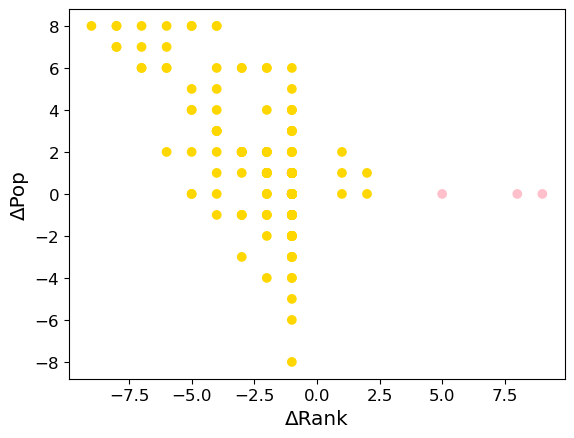

In [805]:
d_pop, d_rank, color = [], [], []
out_path = "docking_poses/DiffDock_2023/self_cross_dock/"

for _, row in allo_crd_1.drop_duplicates("PDB_chain_LIG").iterrows():
    i = row.ind
    pdb_fn = row.PDB_fn
    lig = row.LIG
    lo_label = row.lo_label

    lig_fns = sorted(glob(f'{out_path}/index{i}/rank*_*.sdf'), \
                     key=lambda x: int(os.path.basename(x).split('_')[0].split('.')[0][4:]))
    
    rmsd_l, cent_dist =  get_rmsd_to_ref_crd(align_ref[f'{pdb_fn}-{lig}'], \
                                             lig_fns, mol2_type="fn")
    
    if any([x < 5.0 for x in cent_dist]):
        print(i)
        r, p = get_crossdocking_bias(lig_fns, allo_crd_2[allo_crd_2.ind==i], cent_dist, lt=5.0)
        d_pop.append(p)
        d_rank.append(r)
        color.append(lo_label)

color_list = ['gold', 'pink']
plt.scatter(d_rank, d_pop, color = [color_list[x] for x in color])
plt.xlabel(f"ΔRank")
plt.ylabel(f"ΔPop")

9
{1: [1, 2, 8], 3: [3], 4: [4], 5: [5, 9], 6: [6, 7], 10: [10]}
11
{1: [1, 2, 9], 3: [3], 4: [4, 10], 5: [5], 6: [6], 7: [7, 8]}
37
{1: [1, 5, 10], 2: [2, 3, 6], 4: [4, 8, 9], 7: [7]}
38
{1: [1, 3], 2: [2, 7, 9], 4: [4], 5: [5, 8], 6: [6], 10: [10]}
39
{1: [1, 4, 6, 7], 2: [2, 3], 5: [5], 8: [8], 9: [9], 10: [10]}
65
{1: [1, 3], 2: [2, 4, 6, 7, 10], 5: [5], 8: [8], 9: [9]}
66
{1: [1, 10], 2: [2], 3: [3, 7], 4: [4], 5: [5], 6: [6], 8: [8], 9: [9]}
67
{1: [1, 2, 4, 7, 8, 9, 10], 3: [3], 5: [5, 6]}
93
{1: [1], 2: [2], 3: [3], 4: [4, 7], 5: [5], 6: [6, 9], 8: [8], 10: [10]}
94
{1: [1, 2, 8], 3: [3], 4: [4, 10], 5: [5], 6: [6], 7: [7], 9: [9]}
95
{1: [1, 2, 4], 3: [3, 5], 6: [6, 8], 7: [7], 9: [9], 10: [10]}
121
{1: [1, 6], 2: [2, 3, 5, 8, 10], 4: [4, 7, 9]}
122
{1: [1, 2, 3, 4, 6, 7, 8, 9, 10], 5: [5]}
123
{1: [1], 2: [2, 8, 10], 3: [3], 4: [4, 6, 9], 5: [5], 7: [7]}
149
{1: [1, 2, 3, 4, 10], 5: [5], 6: [6, 7], 8: [8], 9: [9]}
150
{1: [1, 3, 4, 6, 7, 9], 2: [2], 5: [5, 10], 8: [8]}
151
{1

Text(0, 0.5, 'ΔPop')

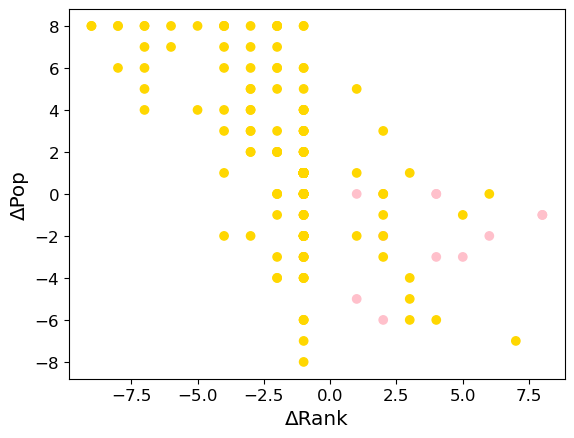

In [819]:
d_pop, d_rank, color = [], [], []
out_path = "docking_poses/DiffDock_LRD/self_cross_dock/"

for _, row in allo_crd_1.drop_duplicates("PDB_chain_LIG").iterrows():
    i = row.ind
    pdb_fn = row.PDB_fn
    lig = row.LIG
    lo_label = row.lo_label

    lig_fns = sorted(glob(f'{out_path}/index{i}/rank*.pdb'), \
                     key=lambda x: int(os.path.basename(x).split('.')[0].strip('rank')))
    
    rmsd_l, cent_dist =  get_rmsd_to_ref_crd(align_ref[f'{pdb_fn}-{lig}'], \
                                             lig_fns, mol2_type="fn")
    
    if any([x < 5.0 for x in cent_dist]):
        print(i)
        r, p = get_crossdocking_bias(lig_fns, allo_crd_2[allo_crd_2.ind==i], cent_dist, lt=5.0)
        d_pop.append(p)
        d_rank.append(r)
        color.append(lo_label)

color_list = ['gold', 'pink']
plt.scatter(d_rank, d_pop, color = [color_list[x] for x in color])
plt.xlabel(f"ΔRank")
plt.ylabel(f"ΔPop")

In [ ]:
d_pop, d_rank, color = [], [], []
out_path = "./docking_poses/DiffDock-S/self_cross_dock/"

df_S = df_S.loc[df_S.PDB_chain.isin(ro_ts_pca.PDB_chain)].reset_index(drop=True)
df_S_crd = df_S[~df_S.PDB_chain_LIG.isin(sd_cdk2.PDB_chain_LIG)]

for name, lr_label in \
    zip(df_S_crd.drop_duplicates(["ind", "PDB_chain_LIG"]).name,\
        df_S_crd.drop_duplicates(["ind", "PDB_chain_LIG"]).lig_lr_label):
    lig_fns = sorted(glob(f'{out_path}/{name}_*.pdb'), \
                     key=lambda x: -float(os.path.basename(x).strip('.pdb').split('/')[-1].split('_')[4]))
    cent_dist = df_S_crd[df_S_crd.name==name].cent_dist.to_list()

    if any([x < 5.0 for x in cent_dist]):
        r, p = get_crossdocking_bias(lig_fns, df_S_crd[df_S_crd.name==name], cent_dist, lt=5, mol1_type = "dd_pdb", mol2_type = "dd_pdb")
        d_pop.append(p)
        d_rank.append(r)
        color.append(lr_label)


{1: [1, 3, 4], 2: [2], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 3], 4: [4, 10], 5: [5, 6, 7, 9], 8: [8]}
{1: [1], 2: [2], 3: [3, 7], 4: [4], 5: [5], 6: [6], 8: [8], 9: [9, 10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9], 10: [10]}
{1: [1, 3, 4, 5, 6, 7, 8, 9, 10], 2: [2]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 3, 4, 5, 7], 6: [6, 8, 9, 10]}
{1: [1, 3, 4, 9], 2: [2, 5, 6, 7, 8, 10]}
{1: [1], 2: [2], 3: [3, 4, 5, 7], 6: [6, 8, 9, 10]}
{1: [1, 5, 9, 10], 2: [2, 3, 4, 6, 7, 8]}
{1: [1, 2, 4, 7], 3: [3, 5, 6, 8], 9: [9], 10: [10]}
{1: [1, 2, 4, 8], 3: [3, 6, 7], 5: [5, 10], 9: [9]}


[16:50:15] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:15] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:15] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:15] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:15] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:15] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:15] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:15] Explicit valence for atom # 30 C, 5, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_1_2.1_1.1.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_10_1.7_-3.4.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_2_1.8_0.5.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_10_1.7_-3.4.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_3_3.5_0.1.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_10_1.7_-3.4.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_5_1.6_-1.8.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_10_1.7_-3.4.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_6_1.8_-2.0.pdb:6, ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_10_1.7_-3.4.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_7_1.7_-2.3.pdb:7, ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_10_1.7_-3.4.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_9_1.8_-3.1.pdb:8, ./docking_poses/DiffDock-S

[16:50:16] Problem with coordinates for PDB atom #1
[16:50:16] Problem with coordinates for PDB atom #1
[16:50:16] Problem with coordinates for PDB atom #1
[16:50:16] Problem with coordinates for PDB atom #1


skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-2PU_1_7.8_-4.3.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-2PU_10_inf_-1000.0.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-2PU_6_3.3_-5.2.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-2PU_10_inf_-1000.0.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-2PU_5_3.0_-5.2.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-2PU_10_inf_-1000.0.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-2PU_3_7.6_-5.2.pdb:6, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-2PU_10_inf_-1000.0.pdb:10
{1: [1, 2], 3: [3, 5, 7, 8, 9], 4: [4], 6: [6], 10: [10]}
{1: [1, 2, 3, 5, 6, 7, 8, 9, 10], 4: [4]}
{1: [1, 2, 4, 5, 6, 7, 8, 9], 3: [3], 10: [10]}
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-ATP_1_1.8_-4.8.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-ATP_4_1.6_-5.2.pdb:3
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-ATP_2_1.9_-5.0.pdb:2, ./docking_poses

[16:50:17] Explicit valence for atom # 22 O, 3, is greater than permitted
[16:50:17] Explicit valence for atom # 22 O, 3, is greater than permitted
[16:50:17] Explicit valence for atom # 22 O, 3, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-ATP_4_1.6_-5.2.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-ATP_10_1.8_-7.5.pdb:5
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 3, 4, 5, 7, 8, 10], 6: [6, 9]}
{1: [1, 2, 3, 4, 5, 6, 7, 9], 8: [8, 10]}
{1: [1], 2: [2, 3], 4: [4, 5, 6, 7], 8: [8], 9: [9], 10: [10]}
{1: [1, 4], 2: [2, 3], 5: [5, 6, 7, 9], 8: [8, 10]}
{1: [1, 2, 3, 4, 6, 7, 8], 5: [5], 9: [9], 10: [10]}
{1: [1], 2: [2], 3: [3, 4], 5: [5, 8, 9], 6: [6], 7: [7], 10: [10]}
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_1_2.4_1.2.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_2_2.3_0.1.pdb:2
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_1_2.4_1.2.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_3_2.4_0.0.pdb:3
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_1_2.4_1.2.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_4_2.0_-0.3.pdb:4
skip ./docking

[16:50:18] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:18] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:18] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:18] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:19] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:19] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:19] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:19] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:19] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:19] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:19] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:19] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:19] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:19] Explicit valence for atom #

skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_1_2.4_1.2.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_9_2.0_-1.3.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_4_2.0_-0.3.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_9_2.0_-1.3.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_1_2.4_1.2.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_10_2.5_-1.5.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_4_2.0_-0.3.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_10_2.5_-1.5.pdb:10
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}


[16:50:19] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:19] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:19] Explicit valence for atom # 30 C, 5, is greater than permitted


{1: [1, 2, 6], 3: [3], 4: [4], 5: [5], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1], 2: [2], 3: [3], 4: [4, 8, 9], 5: [5], 6: [6], 7: [7], 10: [10]}
{1: [1], 2: [2, 3, 4, 5, 6, 7], 8: [8, 9], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 8, 9, 10], 7: [7]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 3], 2: [2, 6, 7, 9], 4: [4, 8], 5: [5], 10: [10]}
{1: [1, 2, 3, 4, 8], 5: [5, 6, 7, 9, 10]}
{1: [1, 2, 3], 4: [4], 5: [5], 6: [6, 7], 8: [8], 9: [9], 10: [10]}
{1: [1], 2: [2, 3, 4, 5, 6, 7], 8: [8, 10], 9: [9]}
{1: [1, 2, 3, 4, 6, 8], 5: [5, 7, 9], 10: [10]}
{1: [1, 3, 5], 2: [2, 4], 6: [6, 7, 9], 8: [8, 10]}
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_1_2.1_0.8.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_2_2.0_0.7.pdb:2
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_1_2.1_0.8.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_3_2.0_0.6.pdb:3
skip ./docking_poses/DiffDock-S/

[16:50:22] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 30 

skip ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_3_2.0_0.6.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_7_2.0_-0.1.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_5_2.8_0.4.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_7_2.0_-0.1.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_2_2.0_0.7.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_9_1.9_-0.2.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_3_2.0_0.6.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_9_1.9_-0.2.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_5_2.8_0.4.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_9_1.9_-0.2.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_2_2.0_0.7.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_8_2.0_-0.2.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_3_2.0_0.6.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock

[16:50:22] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 2 C, 5, is greater than permitted


{1: [1], 2: [2], 3: [3, 5, 6], 4: [4], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1], 2: [2], 3: [3, 6], 4: [4, 5], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 7], 3: [3], 4: [4, 5, 6, 9, 10], 8: [8]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5, 6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8], 9: [9], 10: [10]}
{1: [1, 2, 4, 5, 6, 8, 10], 3: [3], 7: [7, 9]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 5, 6, 7, 9], 3: [3, 4, 8, 10]}
{1: [1, 2, 3, 4, 7, 8, 10], 5: [5, 6], 9: [9]}
{1: [1], 2: [2, 3, 4, 5], 6: [6, 7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 3], 4: [4], 5: [5], 6: [6, 7], 8: [8, 10], 9: [9]}
{1: [1], 2: [2, 3, 5, 9, 10], 4: [4, 8], 6: [6], 7: [7]}
{1: [1], 2: [2, 3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}


[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_1_1.2_3.5.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_5_1.4_2.8.pdb:5
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_2_1.6_3.3.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_5_1.4_2.8.pdb:5
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_3_1.3_3.0.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_5_1.4_2.8.pdb:5
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_4_1.5_3.0.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_5_1.4_2.8.pdb:5
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_5_1.4_2.8.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_6_3.0_2.1.pdb:6
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_5_1.4_2.8.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_7_3.0_2.0.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_5_1.4_2.8.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/1JST_

[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom #

skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_1_1.2_3.5.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_9_3.0_0.4.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_2_1.6_3.3.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_9_3.0_0.4.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_3_1.3_3.0.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_9_3.0_0.4.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_4_1.5_3.0.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_9_3.0_0.4.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_5_1.4_2.8.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_9_3.0_0.4.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_6_3.0_2.1.pdb:6, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_9_3.0_0.4.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_7_3.0_2.0.pdb:7, ./docking_poses/DiffDock-S/self_cross_dock/1JST_

[16:50:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:36] Explicit valence for atom #

skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_6_1.9_-4.3.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_9_2.2_-4.5.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_7_1.9_-4.4.pdb:7, ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_9_2.2_-4.5.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_6_1.9_-4.3.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_8_1.8_-4.5.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_7_1.9_-4.4.pdb:7, ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_8_1.8_-4.5.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_6_1.9_-4.3.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_10_2.3_-4.7.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_7_1.9_-4.4.pdb:7, ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_10_2.3_-4.7.pdb:10
{1: [1], 2: [2], 3: [3, 4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
skip ./docking_poses/DiffDock-

[16:50:36] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:36] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:36] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:36] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:36] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:36] Explicit valence for atom # 9 O, 3, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-WG1_3_2.1_-3.0.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-WG1_8_2.4_-3.8.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-WG1_3_2.1_-3.0.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-WG1_9_2.4_-3.8.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-WG1_3_2.1_-3.0.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-WG1_10_2.4_-4.6.pdb:10
{1: [1, 2, 5], 3: [3], 4: [4], 6: [6], 7: [7], 8: [8], 9: [9, 10]}


[16:50:36] Explicit valence for atom # 9 O, 3, is greater than permitted


{1: [1, 7, 9], 2: [2], 3: [3, 5], 4: [4], 6: [6], 8: [8], 10: [10]}
{1: [1, 2], 3: [3], 4: [4, 5, 6, 7, 9, 10], 8: [8]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9], 10: [10]}
{1: [1, 2, 3, 6, 7], 4: [4, 5], 8: [8, 9, 10]}
{1: [1, 2], 3: [3], 4: [4, 5, 6, 7, 8], 9: [9, 10]}
{1: [1, 3], 2: [2], 4: [4], 5: [5, 6, 8], 7: [7, 9, 10]}
{1: [1, 2, 6, 8, 9, 10], 3: [3, 4, 5, 7]}
{1: [1], 2: [2, 4, 5, 8], 3: [3], 6: [6], 7: [7], 9: [9], 10: [10]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 5], 2: [2, 9], 3: [3], 4: [4], 6: [6], 7: [7], 8: [8], 10: [10]}
{1: [1, 3], 2: [2], 4: [4, 5, 6, 8], 7: [7], 9: [9], 10: [10]}
{1: [1, 2], 3: [3], 4: [4, 5, 6], 7: [7, 9], 8: [8], 10: [10]}
{1: [1], 2: [2], 3: [3], 4: [4, 6], 5: [5], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1,

[16:50:41] Explicit valence for atom # 19 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 19 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 19 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 19 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 19 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 19 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 19 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 19 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 19 O, 3, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-T7Z_6_1.5_-1.0.pdb:6, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-T7Z_10_1.4_-3.1.pdb:10
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7, 9], 8: [8], 10: [10]}
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_1_1.5_-1.6.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_3_2.0_-2.2.pdb:3
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_2_2.0_-2.0.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_3_2.0_-2.2.pdb:3
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_3_2.0_-2.2.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_4_1.4_-2.4.pdb:4
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_3_2.0_-2.2.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_6_1.6_-2.7.pdb:5


[16:50:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 9 O, 3, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_3_2.0_-2.2.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_5_1.5_-2.7.pdb:6
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_1_1.5_-1.6.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_8_1.8_-3.0.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_2_2.0_-2.0.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_8_1.8_-3.0.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_3_2.0_-2.2.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_8_1.8_-3.0.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_4_1.4_-2.4.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_8_1.8_-3.0.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_6_1.6_-2.7.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_8_1.8_-3.0.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_5_1.5_-2.7.pdb:6, ./docking_poses/DiffDock-S/self_cro

[16:50:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:42] Explicit valence for atom # 9 O, 3, is greater than permitted


{1: [1, 7], 2: [2], 3: [3, 8], 4: [4, 5], 6: [6], 9: [9], 10: [10]}
{1: [1, 2, 3], 4: [4, 5, 6, 9], 7: [7], 8: [8, 10]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7, 10], 8: [8], 9: [9]}
{1: [1, 2, 3, 4, 6, 7, 8], 5: [5, 9, 10]}
{1: [1, 2, 3, 4, 5, 6], 7: [7, 9, 10], 8: [8]}
{1: [1], 2: [2, 3], 3: [3], 4: [4], 5: [5]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-CK4_1_0.5_1.0.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-CK4_10_inf_-1000.0.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-CK4_4_0.6_0.5.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-CK4_10_inf_-1000.0.pdb:10
{1: [1, 2, 4, 5, 6, 8, 9], 3: [3, 7], 10: [10]}


[16:50:43] Problem with coordinates for PDB atom #1
[16:50:43] Problem with coordinates for PDB atom #1


{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1], 2: [2, 3], 4: [4, 5, 6, 8], 7: [7, 9], 10: [10]}
{1: [1, 2, 5, 6, 7, 8], 3: [3], 4: [4], 9: [9, 10]}


[16:50:44] Problem with coordinates for PDB atom #1
[16:50:44] Problem with coordinates for PDB atom #1
[16:50:44] Problem with coordinates for PDB atom #1
[16:50:44] Problem with coordinates for PDB atom #1
[16:50:44] Problem with coordinates for PDB atom #1
[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-SQ9_1_1.2_-4.2.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-SQ9_10_inf_-1000.0.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-SQ9_2_1.1_-4.3.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-SQ9_10_inf_-1000.0.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-SQ9_3_1.0_-4.4.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-SQ9_10_inf_-1000.0.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-SQ9_4_1.3_-4.4.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-SQ9_10_inf_-1000.0.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-SQ9_8_7.6_-4.9.pdb:8, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-SQ9_10_inf_-1000.0.pdb:10
{1: [1, 5], 2: [2, 7], 3: [3], 4: [4, 6], 8: [8, 9], 10: [10]}
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_1_3.8_3.6.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_4_2.1_0.8.pdb:4
skip ./docking_poses/DiffD

[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_1_3.8_3.6.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_8_1.5_-0.4.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_2_1.5_1.7.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_8_1.5_-0.4.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_4_2.1_0.8.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_8_1.5_-0.4.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_5_1.7_0.2.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_8_1.5_-0.4.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_6_1.3_-0.0.pdb:6, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_8_1.5_-0.4.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_7_1.3_-0.2.pdb:7, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_8_1.5_-0.4.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_4_2.1_0.8.pdb:4, ./docking_poses/DiffDock-S/self_cross_do

[16:50:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:47] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:47] Explicit valence for atom # 9 O, 3, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-T7Z_6_3.1_-4.9.pdb:8, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-T7Z_5_2.7_-4.9.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-T7Z_6_3.1_-4.9.pdb:8, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-T7Z_4_3.1_-4.9.pdb:10
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_1_2.3_-4.8.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_1_2.7_-4.9.pdb:2
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_1_2.7_-4.9.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_3_2.3_-5.0.pdb:3
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_1_2.7_-4.9.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_4_2.3_-5.0.pdb:4
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_1_2.7_-4.9.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_5_2.3_-5.0.pdb:5


[16:50:47] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:47] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:48] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:48] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:48] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:48] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:48] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:48] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:48] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:48] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:48] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:48] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:48] Explicit valence for atom # 9 O, 3, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_1_2.7_-4.9.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_2_2.3_-5.0.pdb:6
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_1_2.3_-4.8.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_3_2.7_-5.0.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_1_2.7_-4.9.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_3_2.7_-5.0.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_3_2.3_-5.0.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_3_2.7_-5.0.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_4_2.3_-5.0.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_3_2.7_-5.0.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_5_2.3_-5.0.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_3_2.7_-5.0.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_1_2.7_-4.9.pdb:2, ./docking_poses/DiffDock-S/self_cro

[16:50:48] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:48] Explicit valence for atom # 9 O, 3, is greater than permitted


{1: [1, 2], 3: [3], 4: [4, 6], 5: [5, 7], 8: [8], 9: [9], 10: [10]}
{1: [1, 3, 5, 6], 2: [2, 4, 8], 7: [7, 10], 9: [9]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9], 10: [10]}
{1: [1, 2], 3: [3, 4, 5, 9, 10], 6: [6, 7, 8]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 5, 6, 8, 9], 3: [3], 4: [4], 7: [7], 10: [10]}
{1: [1, 2, 3, 5, 6, 10], 4: [4, 7, 8, 9]}
{1: [1, 2, 3, 4], 5: [5], 6: [6, 7], 8: [8, 10], 9: [9]}
{1: [1, 2, 3, 7, 9, 10], 4: [4, 5, 8], 6: [6]}
{1: [1, 3, 7, 8, 10], 2: [2, 4, 5, 6, 9]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7, 8], 9: [9], 10: [10]}


[16:50:51] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 30 C, 

skip ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_1_3.6_-2.5.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_3_3.7_-3.3.pdb:5
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_1_3.7_-2.7.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_3_3.7_-3.3.pdb:5
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_2_3.0_-2.7.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_3_3.7_-3.3.pdb:5
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_2_3.3_-3.1.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_3_3.7_-3.3.pdb:5
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_3_3.7_-3.3.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_4_3.9_-3.4.pdb:6
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_3_3.7_-3.3.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_4_3.1_-3.5.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_1_3.6_-2.5.pdb:1, ./docking_poses/DiffDock-S/self_cro

[16:50:51] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 30 C, 5, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_3_3.7_-3.3.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_5_3.1_-3.5.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_3_3.1_-3.5.pdb:8, ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_5_3.1_-3.5.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_3_3.7_-3.3.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_5_3.1_-3.6.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_3_3.1_-3.5.pdb:8, ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_5_3.1_-3.6.pdb:10
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 3], 2: [2], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1], 2: [2, 7, 8], 3: [3, 6], 4: [4], 5: [5], 9: [9], 10: [10]}
{1: [1, 2, 3, 5, 6], 4: [4], 7: [7, 9], 8: [8], 10: [10]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 4, 5, 6, 7, 9, 10], 3: [3

[16:50:53] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:53] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:54] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:54] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:54] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:54] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:54] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:54] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:54] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:54] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:54] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:54] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:54] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:54] Explicit valence for atom # 9 O, 3, is g

skip ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_1_1.7_3.9.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_9_1.9_2.6.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_3_1.6_3.5.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_9_1.9_2.6.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_2_1.6_3.5.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_9_1.9_2.6.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_4_1.8_3.4.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_9_1.9_2.6.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_5_1.7_3.4.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_9_1.9_2.6.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_6_1.8_3.3.pdb:6, ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_9_1.9_2.6.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_1_1.7_3.9.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/4BCM_

[16:50:56] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:56] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:56] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:56] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:56] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:56] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:56] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:56] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:56] Explicit valence for atom # 30 C, 5, is greater than permitted


{1: [1], 2: [2, 4], 3: [3], 5: [5], 6: [6], 7: [7, 8], 9: [9], 10: [10]}
{1: [1], 2: [2, 4], 3: [3], 5: [5], 6: [6, 7, 8], 9: [9], 10: [10]}
{1: [1, 2, 3, 4, 5, 8], 6: [6, 9, 10], 7: [7]}
{1: [1], 2: [2], 3: [3], 4: [4, 9], 5: [5], 6: [6], 7: [7], 8: [8], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8], 9: [9, 10]}
skip ./docking_poses/DiffDock-S/self_cross_dock/4FKG_A-ATP_1_1.7_-2.4.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/4FKG_A-ATP_4_1.4_-3.0.pdb:2
skip ./docking_poses/DiffDock-S/self_cross_dock/4FKG_A-ATP_2_1.4_-2.5.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/4FKG_A-ATP_4_1.4_-3.0.pdb:2
skip ./docking_poses/DiffDock-S/self_cross_dock/4FKG_A-ATP_4_1.4_-3.0.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/4FKG_A-ATP_9_2.0_-4.5.pdb:4
skip ./docking_poses/DiffDock-S/self_cross_dock/4FKG_A-ATP_4_1.4_-3.0.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/4FKG_A-ATP_8_2.0_-4.5.pdb:5
skip ./docking_poses/DiffDock-S/self_cross_dock/4FKG_A-ATP_4_1.4_-3.0.pdb:4, ./docking_poses/DiffDoc

[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_1_3.0_3.5.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_8_1.7_0.5.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_1_3.0_3.5.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_9_1.7_-0.8.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_7_1.4_0.5.pdb:7, ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_9_1.7_-0.8.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_1_3.0_3.5.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_10_1.6_-2.1.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_7_1.4_0.5.pdb:7, ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_10_1.6_-2.1.pdb:10
{1: [1], 2: [2], 3: [3], 4: [4, 5], 6: [6, 8], 7: [7], 9: [9], 10: [10]}


[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted


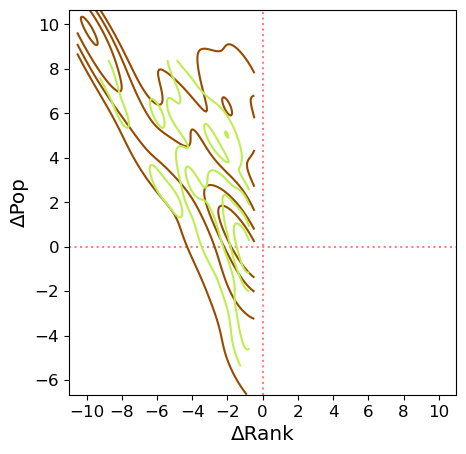

In [357]:
import seaborn as sns
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1,1,figsize=(5,5))

def kde_subplot(ax, d_rank, d_pop, color):
    ax.set_xlim(-11,11)
    ax.set_xlim(-11,11)
    ax.set_xticks(range(-10,11,2))
    ax.set_yticks(range(-10,11,2))
    ax.set_xlabel(f"ΔRank")
    ax.set_ylabel(f"ΔPop")
    ax.axhline(y=0, color='r', linestyle=':', alpha=0.5)
    ax.axvline(x=0, color='r', linestyle=':', alpha=0.5)

    marker_dict = {
        (1, 0) : {"color" : "#964B00"},
        (2, 0) : {"color" : "#bdee50"},
        (1, 1) : {"color" : "pink"},
    }

    for i, col in enumerate([(1, 0), (1, 1), (2, 0)]):
        sel = np.where(np.all(np.asarray(color) == col, axis=1))
        sns.kdeplot(x=np.asarray(d_rank)[sel],y=np.asarray(d_pop)[sel], levels=5, cut = 0.5, \
                    **marker_dict[col], bw_method=0.3, ax=ax)
    
kde_subplot(ax, d_rank, d_pop, color)

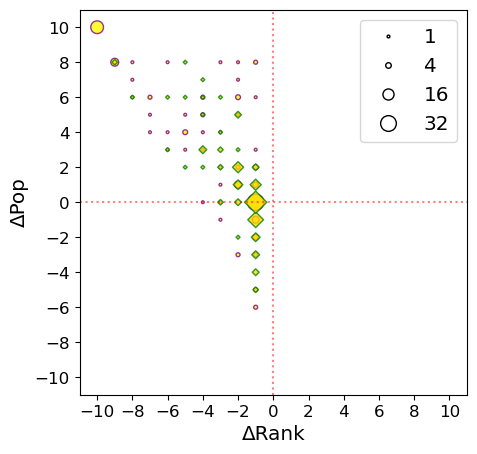

In [ ]:
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(5,5))
plt.xlim(-11,11)
plt.ylim(-11,11)
plt.xticks(range(-10,11,2))
plt.yticks(range(-10,11,2))
plt.xlabel(f"ΔRank")
plt.ylabel(f"ΔPop")
plt.axhline(y=0, color='r', linestyle=':', alpha=0.5)
plt.axvline(x=0, color='r', linestyle=':', alpha=0.5)

marker_dict = {
    (1, 0) : {"color" : "yellow", "edgecolors" : "purple",   "marker" : "o"},
    (2, 0) : {"color" : "gold", "edgecolors" : "green", "marker" : "D"},
    (1, 1) : {"color" : "pink", "marker" : "X"},
}

for i, col in enumerate([(1, 0),(2, 0),  (1, 1), ]):
    sel = np.where(np.all(np.asarray(color) == col, axis=1))
    counts,ybins,xbins = np.histogram2d(np.asarray(d_rank)[sel],np.asarray(d_pop)[sel],\
                                        bins=(np.arange(-10.5,11.5,1), np.arange(-10.5,11.5,1)))
    
    xcenters = (xbins[:-1] + xbins[1:]) / 2
    ycenters = (ybins[:-1] + ybins[1:]) / 2
    X, Y = np.meshgrid(xcenters, ycenters)

    x_points = X.flatten()
    y_points = Y.flatten()
    z_values = counts.T.flatten()

    nonzero = z_values > 0
    x_points = x_points[nonzero]
    y_points = y_points[nonzero]
    z_values = z_values[nonzero]
    # ax[i].set_aspect('equal', adjustable='box')
    plt.scatter(x_points, y_points, s=z_values * 4, alpha=0.8, **marker_dict[col])

    # print(z_values.max())

legend_sizes = [1, 4, 16, 32]  # Example histogram counts
legend_markers = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='white', 
           markersize=np.sqrt(size * 4), markeredgecolor='k') 
    for size in legend_sizes
]

plt.legend(
    legend_markers, 
    [f"{size}" for size in legend_sizes],
    loc="upper right")


In [63]:
for name, lo_label in zip(df_L_crd.drop_duplicates(["ind", "PDB_chain_LIG"]).name,\
                          df_L_crd.drop_duplicates(["ind", "PDB_chain_LIG"]).lo_label):
    lig_fns = sorted(glob(f'{out_path}/{name}_*.pdb'), \
                     key=lambda x: -float(os.path.basename(x).strip('.pdb').split('/')[-1].split('_')[4]))
    cent_dist = df_L_crd[df_L_crd.name==name].cent_dist.to_list()

    if any([x < 5.0 for x in cent_dist]) and (lo_label == 1):
        break

{1: [1, 2], 3: [3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 3, 4, 5], 6: [6, 7], 8: [8], 9: [9], 10: [10]}
{1: [1], 2: [2], 3: [3], 4: [4, 5, 6], 7: [7, 8], 9: [9, 10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 3, 4, 5, 7, 8, 9, 10], 6: [6]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1], 2: [2, 3, 4, 5, 6, 7, 8], 9: [9], 10: [10]}
{1: [1], 2: [2, 3, 4, 8], 5: [5], 6: [6], 7: [7, 9], 10: [10]}
{1: [1, 2, 3, 4, 5, 6], 7: [7, 8, 9, 10]}
{1: [1, 2, 5], 3: [3], 4: [4, 6, 7, 8, 9, 10]}
{1: [1], 2: [2], 3: [3, 4, 7, 9], 5: [5], 6: [6], 8: [8], 10: [10]}
{1: [1, 3, 6, 7, 8, 9, 10], 2: [2, 4], 5: [5]}
{1: [1, 2], 3: [3], 4: [4, 5, 6, 7, 8, 9, 10]}
{1: [1, 3], 2: [2], 4: [4], 5: [5, 8, 9], 6: [6, 7], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}


[18:22:06] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:22:06] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:22:06] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:22:06] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:22:06] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:22:06] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:22:06] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:22:06] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:22:06] Explicit valence for atom # 17 O, 3, is greater than permitted


skip ./docking_poses/DiffDock-L/self_cross_dock/1GIH_A-ATP_1_2.0_-0.9.pdb:1, ./docking_poses/DiffDock-L/self_cross_dock/1GIH_A-ATP_5_2.4_-1.1.pdb:6
skip ./docking_poses/DiffDock-L/self_cross_dock/1GIH_A-ATP_3_1.3_-1.0.pdb:2, ./docking_poses/DiffDock-L/self_cross_dock/1GIH_A-ATP_5_2.4_-1.1.pdb:6
skip ./docking_poses/DiffDock-L/self_cross_dock/1GIH_A-ATP_2_2.2_-1.0.pdb:3, ./docking_poses/DiffDock-L/self_cross_dock/1GIH_A-ATP_5_2.4_-1.1.pdb:6
skip ./docking_poses/DiffDock-L/self_cross_dock/1GIH_A-ATP_7_2.3_-1.1.pdb:4, ./docking_poses/DiffDock-L/self_cross_dock/1GIH_A-ATP_5_2.4_-1.1.pdb:6
skip ./docking_poses/DiffDock-L/self_cross_dock/1GIH_A-ATP_6_2.4_-1.1.pdb:5, ./docking_poses/DiffDock-L/self_cross_dock/1GIH_A-ATP_5_2.4_-1.1.pdb:6
skip ./docking_poses/DiffDock-L/self_cross_dock/1GIH_A-ATP_5_2.4_-1.1.pdb:6, ./docking_poses/DiffDock-L/self_cross_dock/1GIH_A-ATP_4_2.3_-1.1.pdb:7
skip ./docking_poses/DiffDock-L/self_cross_dock/1GIH_A-ATP_5_2.4_-1.1.pdb:6, ./docking_poses/DiffDock-L/self_cro

[18:22:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:08] Explicit valence for atom #

skip ./docking_poses/DiffDock-L/self_cross_dock/1GIH_A-T7Z_2_3.4_-0.8.pdb:1, ./docking_poses/DiffDock-L/self_cross_dock/1GIH_A-T7Z_5_1.9_-1.1.pdb:6
skip ./docking_poses/DiffDock-L/self_cross_dock/1GIH_A-T7Z_1_3.3_-0.8.pdb:2, ./docking_poses/DiffDock-L/self_cross_dock/1GIH_A-T7Z_5_1.9_-1.1.pdb:6
skip ./docking_poses/DiffDock-L/self_cross_dock/1GIH_A-T7Z_3_2.3_-0.9.pdb:3, ./docking_poses/DiffDock-L/self_cross_dock/1GIH_A-T7Z_5_1.9_-1.1.pdb:6
skip ./docking_poses/DiffDock-L/self_cross_dock/1GIH_A-T7Z_4_2.4_-1.0.pdb:4, ./docking_poses/DiffDock-L/self_cross_dock/1GIH_A-T7Z_5_1.9_-1.1.pdb:6
skip ./docking_poses/DiffDock-L/self_cross_dock/1GIH_A-T7Z_10_2.3_-1.1.pdb:5, ./docking_poses/DiffDock-L/self_cross_dock/1GIH_A-T7Z_5_1.9_-1.1.pdb:6
skip ./docking_poses/DiffDock-L/self_cross_dock/1GIH_A-T7Z_5_1.9_-1.1.pdb:6, ./docking_poses/DiffDock-L/self_cross_dock/1GIH_A-T7Z_7_2.3_-1.1.pdb:7
skip ./docking_poses/DiffDock-L/self_cross_dock/1GIH_A-T7Z_2_3.4_-0.8.pdb:1, ./docking_poses/DiffDock-L/self_cr

[18:22:12] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:12] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:12] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:12] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:12] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:12] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:12] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:12] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:12] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:12] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:12] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:12] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:12] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:12] Explicit valence for atom #

skip ./docking_poses/DiffDock-L/self_cross_dock/1GIJ_A-T7Z_1_1.9_-0.4.pdb:1, ./docking_poses/DiffDock-L/self_cross_dock/1GIJ_A-T7Z_6_2.0_-0.8.pdb:6
skip ./docking_poses/DiffDock-L/self_cross_dock/1GIJ_A-T7Z_2_1.9_-0.5.pdb:2, ./docking_poses/DiffDock-L/self_cross_dock/1GIJ_A-T7Z_6_2.0_-0.8.pdb:6
skip ./docking_poses/DiffDock-L/self_cross_dock/1GIJ_A-T7Z_4_2.0_-0.7.pdb:3, ./docking_poses/DiffDock-L/self_cross_dock/1GIJ_A-T7Z_6_2.0_-0.8.pdb:6
skip ./docking_poses/DiffDock-L/self_cross_dock/1GIJ_A-T7Z_3_1.9_-0.7.pdb:4, ./docking_poses/DiffDock-L/self_cross_dock/1GIJ_A-T7Z_6_2.0_-0.8.pdb:6
skip ./docking_poses/DiffDock-L/self_cross_dock/1GIJ_A-T7Z_5_1.8_-0.7.pdb:5, ./docking_poses/DiffDock-L/self_cross_dock/1GIJ_A-T7Z_6_2.0_-0.8.pdb:6
skip ./docking_poses/DiffDock-L/self_cross_dock/1GIJ_A-T7Z_1_1.9_-0.4.pdb:1, ./docking_poses/DiffDock-L/self_cross_dock/1GIJ_A-T7Z_7_2.3_-0.9.pdb:7
skip ./docking_poses/DiffDock-L/self_cross_dock/1GIJ_A-T7Z_2_1.9_-0.5.pdb:2, ./docking_poses/DiffDock-L/self_cro

[18:22:12] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:12] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:12] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:12] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:12] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:12] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:12] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:12] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:12] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:12] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:12] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:12] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:12] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:12] Explicit valence for atom #

skip ./docking_poses/DiffDock-L/self_cross_dock/1GIJ_A-T7Z_4_2.0_-0.7.pdb:3, ./docking_poses/DiffDock-L/self_cross_dock/1GIJ_A-T7Z_10_3.9_-1.3.pdb:10
skip ./docking_poses/DiffDock-L/self_cross_dock/1GIJ_A-T7Z_3_1.9_-0.7.pdb:4, ./docking_poses/DiffDock-L/self_cross_dock/1GIJ_A-T7Z_10_3.9_-1.3.pdb:10
skip ./docking_poses/DiffDock-L/self_cross_dock/1GIJ_A-T7Z_5_1.8_-0.7.pdb:5, ./docking_poses/DiffDock-L/self_cross_dock/1GIJ_A-T7Z_10_3.9_-1.3.pdb:10
skip ./docking_poses/DiffDock-L/self_cross_dock/1GIJ_A-T7Z_6_2.0_-0.8.pdb:6, ./docking_poses/DiffDock-L/self_cross_dock/1GIJ_A-T7Z_10_3.9_-1.3.pdb:10
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7, 9], 8: [8], 10: [10]}


[18:22:12] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:12] Explicit valence for atom # 30 C, 5, is greater than permitted


{1: [1, 3, 4, 5, 6], 2: [2], 7: [7, 8], 9: [9, 10]}
{1: [1, 3], 2: [2, 4, 5, 6, 7, 8, 9], 10: [10]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5, 6, 7, 8, 9], 10: [10]}
{1: [1], 2: [2], 3: [3], 4: [4, 6, 8, 9], 5: [5, 7], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2], 3: [3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 3, 4], 5: [5, 6, 7, 8, 9], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7], 8: [8, 10], 9: [9]}
{1: [1, 2, 3, 4], 5: [5], 6: [6, 7, 8, 9, 10]}
{1: [1, 2], 3: [3, 4, 5, 6, 7, 9, 10], 8: [8]}
skip ./docking_poses/DiffDock-L/self_cross_dock/1JST_A-T7Z_1_1.0_-0.6.pdb:1, ./docking_poses/DiffDock-L/self_cross_dock/1JST_A-T7Z_2_0.8_-0.7.pdb:2
skip ./docking_poses/DiffDock-L/self_cross_dock/1JST_A-T7Z_2_0.8_-0.7.pdb:2, ./docking_poses/DiffDock-L/self_cross_dock/1JST_A-T7Z_3_1.2_-0.8.pdb:3
skip ./docking_poses/DiffDock-L/self_cross_dock/1JST_A-T7Z_2_0.8_-0.7.pdb:2, ./docking_poses/DiffDo

[18:22:16] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:16] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:16] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:16] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:16] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:16] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:16] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:16] Explicit valence for atom # 30 C, 5, is greater than permitted


skip ./docking_poses/DiffDock-L/self_cross_dock/1JST_A-T7Z_2_0.8_-0.7.pdb:2, ./docking_poses/DiffDock-L/self_cross_dock/1JST_A-T7Z_6_1.2_-0.9.pdb:8
skip ./docking_poses/DiffDock-L/self_cross_dock/1JST_A-T7Z_2_0.8_-0.7.pdb:2, ./docking_poses/DiffDock-L/self_cross_dock/1JST_A-T7Z_9_0.8_-1.0.pdb:9
skip ./docking_poses/DiffDock-L/self_cross_dock/1JST_A-T7Z_2_0.8_-0.7.pdb:2, ./docking_poses/DiffDock-L/self_cross_dock/1JST_A-T7Z_10_3.2_-1.4.pdb:10
{1: [1], 2: [2], 3: [3, 6, 8], 4: [4], 5: [5], 7: [7], 9: [9], 10: [10]}


[18:22:16] Explicit valence for atom # 30 C, 5, is greater than permitted


{1: [1, 2, 5], 3: [3], 4: [4, 6, 7, 8, 9, 10]}
{1: [1], 2: [2, 4], 3: [3, 5, 6, 7, 8], 9: [9], 10: [10]}
{1: [1], 2: [2], 3: [3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1], 2: [2, 3], 4: [4], 5: [5], 6: [6], 7: [7, 8, 9, 10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
skip ./docking_poses/DiffDock-L/self_cross_dock/2BHE_A-ATP_1_2.9_-3.3.pdb:1, ./docking_poses/DiffDock-L/self_cross_dock/2BHE_A-ATP_2_2.7_-3.4.pdb:2


[18:22:18] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:22:18] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:22:18] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:22:18] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:22:18] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:22:18] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:22:18] Explicit valence for atom # 17 O, 3, is greater than permitted


skip ./docking_poses/DiffDock-L/self_cross_dock/2BHE_A-ATP_1_2.9_-3.3.pdb:1, ./docking_poses/DiffDock-L/self_cross_dock/2BHE_A-ATP_4_2.7_-3.5.pdb:3
skip ./docking_poses/DiffDock-L/self_cross_dock/2BHE_A-ATP_1_2.9_-3.3.pdb:1, ./docking_poses/DiffDock-L/self_cross_dock/2BHE_A-ATP_5_2.5_-3.5.pdb:4
skip ./docking_poses/DiffDock-L/self_cross_dock/2BHE_A-ATP_1_2.9_-3.3.pdb:1, ./docking_poses/DiffDock-L/self_cross_dock/2BHE_A-ATP_3_2.3_-3.5.pdb:5
skip ./docking_poses/DiffDock-L/self_cross_dock/2BHE_A-ATP_1_2.9_-3.3.pdb:1, ./docking_poses/DiffDock-L/self_cross_dock/2BHE_A-ATP_7_2.5_-3.6.pdb:6
skip ./docking_poses/DiffDock-L/self_cross_dock/2BHE_A-ATP_1_2.9_-3.3.pdb:1, ./docking_poses/DiffDock-L/self_cross_dock/2BHE_A-ATP_9_2.7_-3.6.pdb:7
skip ./docking_poses/DiffDock-L/self_cross_dock/2BHE_A-ATP_1_2.9_-3.3.pdb:1, ./docking_poses/DiffDock-L/self_cross_dock/2BHE_A-ATP_6_2.4_-3.6.pdb:8
skip ./docking_poses/DiffDock-L/self_cross_dock/2BHE_A-ATP_1_2.9_-3.3.pdb:1, ./docking_poses/DiffDock-L/self_cro

[18:22:18] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:22:18] Explicit valence for atom # 17 O, 3, is greater than permitted


skip ./docking_poses/DiffDock-L/self_cross_dock/2BHE_A-ATP_1_2.9_-3.3.pdb:1, ./docking_poses/DiffDock-L/self_cross_dock/2BHE_A-ATP_10_2.4_-3.8.pdb:10
{1: [1], 2: [2], 3: [3], 4: [4, 6, 9], 5: [5], 7: [7], 8: [8], 10: [10]}
{1: [1], 2: [2, 3, 5, 6, 7, 8, 10], 4: [4, 9]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2], 3: [3, 4], 5: [5], 6: [6, 8], 7: [7], 9: [9, 10]}
{1: [1, 2, 3], 4: [4, 5, 6, 7, 8, 9], 10: [10]}
{1: [1, 2, 3, 4], 5: [5, 6, 7, 8, 9, 10]}
{1: [1], 2: [2], 3: [3, 4, 5, 7, 8], 6: [6], 9: [9, 10]}
skip ./docking_poses/DiffDock-L/self_cross_dock/2BHE_A-T7Z_1_2.9_-2.1.pdb:1, ./docking_poses/DiffDock-L/self_cross_dock/2BHE_A-T7Z_2_2.9_-2.3.pdb:2
skip ./docking_poses/DiffDock-L/self_cross_dock/2BHE_A-T7Z_1_2.9_-2.1.pdb:1, ./docking_poses/DiffDock-L/self_cross_dock/2BHE_A-T7Z_3_3.5_-2.4.pdb:3
skip ./docking_poses/DiffDock-L/self_cross_dock/2BHE_A-T7Z_1_2.9_-2.1.pdb:1, ./docking_poses/DiffDock-L/self_cross_dock/2BHE_A-T7Z_4_3.6_-2.5.pdb:4
skip ./docking_poses/DiffDock-L/self_cro

[18:22:36] Explicit valence for atom # 24 O, 3, is greater than permitted
[18:22:36] Explicit valence for atom # 24 O, 3, is greater than permitted
[18:22:36] Explicit valence for atom # 24 O, 3, is greater than permitted
[18:22:36] Explicit valence for atom # 24 O, 3, is greater than permitted
[18:22:36] Explicit valence for atom # 24 O, 3, is greater than permitted
[18:22:36] Explicit valence for atom # 24 O, 3, is greater than permitted
[18:22:36] Explicit valence for atom # 24 O, 3, is greater than permitted
[18:22:36] Explicit valence for atom # 24 O, 3, is greater than permitted


skip ./docking_poses/DiffDock-L/self_cross_dock/3BHT_A-T7Z_1_1.8_-0.1.pdb:1, ./docking_poses/DiffDock-L/self_cross_dock/3BHT_A-T7Z_9_1.3_-1.5.pdb:9
skip ./docking_poses/DiffDock-L/self_cross_dock/3BHT_A-T7Z_2_1.6_-0.4.pdb:2, ./docking_poses/DiffDock-L/self_cross_dock/3BHT_A-T7Z_9_1.3_-1.5.pdb:9
skip ./docking_poses/DiffDock-L/self_cross_dock/3BHT_A-T7Z_3_3.3_-0.8.pdb:3, ./docking_poses/DiffDock-L/self_cross_dock/3BHT_A-T7Z_9_1.3_-1.5.pdb:9
skip ./docking_poses/DiffDock-L/self_cross_dock/3BHT_A-T7Z_4_1.4_-0.9.pdb:4, ./docking_poses/DiffDock-L/self_cross_dock/3BHT_A-T7Z_9_1.3_-1.5.pdb:9
skip ./docking_poses/DiffDock-L/self_cross_dock/3BHT_A-T7Z_7_3.3_-1.0.pdb:6, ./docking_poses/DiffDock-L/self_cross_dock/3BHT_A-T7Z_9_1.3_-1.5.pdb:9
skip ./docking_poses/DiffDock-L/self_cross_dock/3BHT_A-T7Z_6_1.5_-1.0.pdb:7, ./docking_poses/DiffDock-L/self_cross_dock/3BHT_A-T7Z_9_1.3_-1.5.pdb:9
skip ./docking_poses/DiffDock-L/self_cross_dock/3BHT_A-T7Z_8_2.0_-1.3.pdb:8, ./docking_poses/DiffDock-L/self_cro

[18:22:39] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:39] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:39] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:39] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:39] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:39] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:39] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:39] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:39] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:39] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:39] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:39] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:39] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:39] Explicit valence for atom #

{1: [1, 2, 5, 6, 10], 3: [3], 4: [4, 8], 7: [7, 9]}
{1: [1, 2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9, 10]}
{1: [1], 2: [2], 3: [3, 4, 5, 9], 6: [6, 7], 8: [8], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 3, 4, 5, 6, 9], 7: [7, 8, 10]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
skip ./docking_poses/DiffDock-L/self_cross_dock/3PXF_A-ATP_1_1.6_-1.0.pdb:1, ./docking_poses/DiffDock-L/self_cross_dock/3PXF_A-ATP_1_1.4_-1.0.pdb:2
skip ./docking_poses/DiffDock-L/self_cross_dock/3PXF_A-ATP_1_1.4_-1.0.pdb:2, ./docking_poses/DiffDock-L/self_cross_dock/3PXF_A-ATP_4_1.5_-1.1.pdb:3
skip ./docking_poses/DiffDock-L/self_cross_dock/3PXF_A-ATP_1_1.4_-1.0.pdb:2, ./docking_poses/DiffDock-L/self_cross_dock/3PXF_A-ATP_3_1.4_-1.1.pdb:4
skip ./docking_poses/DiffDock-L/self_cross_dock/3PXF_A-ATP_1_1.4_-1.0.pdb:2, ./docking_poses/DiffDock-L/self_cross_dock/3PXF_A-AT

[18:22:40] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:22:40] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:22:40] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:22:40] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:22:40] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:22:40] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:22:40] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:22:40] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:22:40] Explicit valence for atom # 17 O, 3, is greater than permitted


{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 3, 4, 5, 9, 10], 6: [6, 7, 8]}
{1: [1, 2, 3, 4, 8, 10], 5: [5, 6, 7, 9]}
{1: [1], 2: [2, 4], 3: [3, 5, 6, 7, 8, 10], 9: [9]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2], 3: [3, 4, 5, 9], 6: [6, 7, 8, 10]}
{1: [1, 2, 3, 4, 5, 6, 7], 8: [8, 10], 9: [9]}
skip ./docking_poses/DiffDock-L/self_cross_dock/3PXF_A-T7Z_3_3.7_-2.4.pdb:1, ./docking_poses/DiffDock-L/self_cross_dock/3PXF_A-T7Z_2_3.2_-2.4.pdb:2
skip ./docking_poses/DiffDock-L/self_cross_dock/3PXF_A-T7Z_2_3.2_-2.4.pdb:2, ./docking_poses/DiffDock-L/self_cross_dock/3PXF_A-T7Z_1_3.6_-2.4.pdb:3
skip ./docking_poses/DiffDock-L/self_cross_dock/3PXF_A-T7Z_2_3.2_-2.4.pdb:2, ./docking_poses/DiffDock-L/self_cross_dock/3PXF_A-T7Z_6_3.5_-2.6.pdb:5
skip ./docking_poses/DiffDock-L/self_cross_dock/3PXF_A-T7Z_2_3.2_-2.4.pdb:2, ./docking_poses/DiffDock-L/self_cross_dock/3PXF_A-T7Z_7_3.8_-2.6.pdb:6
skip ./docking_poses/DiffDock-L/self_cross_dock/3PXF_A-T7Z_2_3.2_-2.4.pdb:2, ./docking_poses/DiffDock-L/

[18:22:41] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:41] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:41] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:41] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:41] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:41] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:41] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:41] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:41] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:41] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:41] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:41] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:41] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:41] Explicit valence for atom #

{1: [1, 2, 3], 4: [4, 5, 8, 10], 6: [6], 7: [7], 9: [9]}
{1: [1, 6], 2: [2], 3: [3, 4, 7, 10], 5: [5], 8: [8], 9: [9]}
{1: [1, 2, 4], 3: [3], 5: [5, 6, 10], 7: [7], 8: [8, 9]}
{1: [1, 2, 4, 5], 3: [3], 6: [6, 7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 3, 4], 2: [2], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 3, 4, 5, 6, 7, 8, 9, 10], 2: [2]}
{1: [1, 5, 6, 7, 9, 10], 2: [2, 3, 4, 8]}
{1: [1, 2, 4, 5, 6, 7], 3: [3], 8: [8, 10], 9: [9]}
{1: [1], 2: [2, 10], 3: [3, 4, 5, 6, 7, 8, 9]}
{1: [1, 2, 3, 4, 5, 7], 6: [6], 8: [8, 10], 9: [9]}
{1: [1, 3, 4, 8, 9], 2: [2], 5: [5, 6, 7], 10: [10]}
{1: [1, 2], 3: [3, 7], 4: [4, 5, 6, 8, 9, 10]}
{1: [1], 2: [2], 3: [3, 7, 8], 4: [4], 5: [5], 6: [6], 9: [9, 10]}
{1: [1, 2], 3: [3, 4, 5, 6, 7, 8, 9], 10: [10]}
{1: [1, 2, 3, 5, 9], 4: [4], 6: [6, 8], 7: [7], 10: [10]}
{1: [1, 2, 3], 4: [4, 6], 5: [5], 7: [7], 8: [8, 9], 10: [10]}
{1: [1

[18:22:44] Explicit valence for atom # 26 O, 3, is greater than permitted
[18:22:44] Explicit valence for atom # 26 O, 3, is greater than permitted
[18:22:44] Explicit valence for atom # 26 O, 3, is greater than permitted
[18:22:44] Explicit valence for atom # 26 O, 3, is greater than permitted
[18:22:44] Explicit valence for atom # 26 O, 3, is greater than permitted
[18:22:44] Explicit valence for atom # 26 O, 3, is greater than permitted
[18:22:44] Explicit valence for atom # 26 O, 3, is greater than permitted
[18:22:44] Explicit valence for atom # 26 O, 3, is greater than permitted


{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 3, 5, 6, 7, 8, 9, 10], 4: [4]}
{1: [1, 2], 3: [3], 4: [4, 7, 8, 10], 5: [5, 6], 9: [9]}
{1: [1, 2, 3, 4, 5], 6: [6, 7, 8, 9, 10]}
{1: [1], 2: [2, 4, 5], 3: [3, 6], 7: [7], 8: [8, 9, 10]}
{1: [1], 2: [2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 3, 4, 5, 6, 8, 9], 7: [7, 10]}
{1: [1, 2], 3: [3, 7], 4: [4, 5, 6, 8, 9, 10]}
{1: [1], 2: [2, 3, 5], 4: [4], 6: [6, 7, 9, 10], 8: [8]}
{1: [1], 2: [2, 5, 7, 8], 3: [3, 4], 6: [6], 9: [9], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9], 10: [10]}
{1: [1], 2: [2], 3: [3], 4: [4, 5], 6: [6, 8], 7: [7], 9: [9], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 5, 6], 3: [3, 4, 7, 8, 9, 10]}
{1: [1, 2, 3], 4: [4, 5, 6, 7, 8, 9], 10: [10]}
{1: [1, 2, 3, 4, 5], 6: [6, 7, 8, 9], 10: [10]}
{1: [1], 2: [2, 4, 5, 7, 8], 3: [3, 6], 9: [9, 10]}


[18:22:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:47] Explicit valence for atom #

skip ./docking_poses/DiffDock-L/self_cross_dock/4CFW_C-T7Z_1_2.0_-0.2.pdb:1, ./docking_poses/DiffDock-L/self_cross_dock/4CFW_C-T7Z_3_3.4_-0.7.pdb:3
skip ./docking_poses/DiffDock-L/self_cross_dock/4CFW_C-T7Z_2_1.6_-0.6.pdb:2, ./docking_poses/DiffDock-L/self_cross_dock/4CFW_C-T7Z_3_3.4_-0.7.pdb:3
skip ./docking_poses/DiffDock-L/self_cross_dock/4CFW_C-T7Z_1_2.0_-0.2.pdb:1, ./docking_poses/DiffDock-L/self_cross_dock/4CFW_C-T7Z_4_3.3_-0.7.pdb:4
skip ./docking_poses/DiffDock-L/self_cross_dock/4CFW_C-T7Z_2_1.6_-0.6.pdb:2, ./docking_poses/DiffDock-L/self_cross_dock/4CFW_C-T7Z_4_3.3_-0.7.pdb:4
skip ./docking_poses/DiffDock-L/self_cross_dock/4CFW_C-T7Z_3_3.4_-0.7.pdb:3, ./docking_poses/DiffDock-L/self_cross_dock/4CFW_C-T7Z_4_3.3_-0.7.pdb:4
skip ./docking_poses/DiffDock-L/self_cross_dock/4CFW_C-T7Z_1_2.0_-0.2.pdb:1, ./docking_poses/DiffDock-L/self_cross_dock/4CFW_C-T7Z_7_1.1_-0.8.pdb:5
skip ./docking_poses/DiffDock-L/self_cross_dock/4CFW_C-T7Z_2_1.6_-0.6.pdb:2, ./docking_poses/DiffDock-L/self_cro

[18:22:52] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:22:52] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:22:52] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:22:52] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:22:52] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:22:52] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:22:52] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:22:52] Explicit valence for atom # 17 O, 3, is greater than permitted


{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 10], 9: [9]}
{1: [1, 6, 7, 9], 2: [2, 3, 4, 5, 8], 10: [10]}
{1: [1, 2, 3], 4: [4, 5, 6, 7, 8, 9], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7], 8: [8, 9, 10]}
{1: [1, 2], 3: [3, 4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 4, 5, 7, 8, 10], 3: [3, 6, 9]}
{1: [1, 3, 8], 2: [2, 4, 5, 6, 9, 10], 7: [7]}
{1: [1, 2, 3, 4, 5, 6, 7], 8: [8, 9], 10: [10]}
{1: [1], 2: [2, 8], 3: [3, 4, 5, 6], 7: [7], 9: [9], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 4, 5, 6, 7, 8, 10], 3: [3, 9]}
skip ./docking_poses/DiffDock-L/self_cross_dock/7KJS_A-ATP_2_2.6_-1.1.pdb:1, ./docking_poses/DiffDock-L/self_cross_dock/7KJS_A-ATP_10_3.4_-3.8.pdb:10
skip ./docking_poses/DiffDock-L/self_cross_dock/7KJS_A-ATP_1_2.8_-1.1.pdb:2, ./docking_poses/DiffDock-L/self_cross_dock/7KJS_A-ATP_10_3.4_-3.8.pdb:10
skip ./docking_poses/DiffDock-L/self_cross_dock/7KJS_A-ATP_4_2.5_-1.2.pdb:4, ./docking_p

[18:22:56] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:56] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:56] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:56] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:56] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:56] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:56] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:56] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:56] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:56] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:56] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:56] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:56] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:22:56] Explicit valence for atom #

Text(0, 0.5, 'ΔPop')

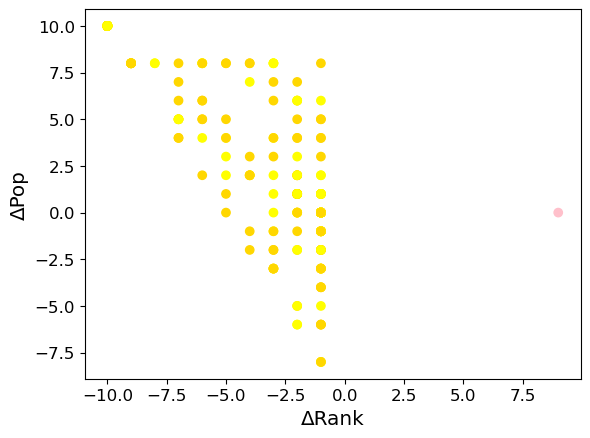

In [374]:
d_pop, d_rank, color = [], [], []
out_path = "./docking_poses/DiffDock-L/self_cross_dock/"

df_L = df_L.loc[df_L.PDB_chain.isin(ro_ts_pca.PDB_chain)].reset_index(drop=True)
df_L_crd = df_L[~df_L.PDB_chain_LIG.isin(sd_cdk2.PDB_chain_LIG)].drop_duplicates(["ind", "rank"])

for name, lr_label in zip(df_L_crd.drop_duplicates(["ind", "PDB_chain_LIG"]).name,\
                          df_L_crd.drop_duplicates(["ind", "PDB_chain_LIG"]).lig_lr_label):
    lig_fns = sorted(glob(f'{out_path}/{name}_*.pdb'), \
                     key=lambda x: -float(os.path.basename(x).strip('.pdb').split('/')[-1].split('_')[4]))
    cent_dist = df_L_crd[df_L_crd.name==name].cent_dist.to_list()

    if any([x < 5.0 for x in cent_dist]):
        r, p = get_crossdocking_bias(lig_fns, df_L_crd[df_L_crd.name==name], cent_dist, lt=5, mol1_type = "dd_pdb", mol2_type = "dd_pdb")
        d_pop.append(p)
        d_rank.append(r)
        color.append(lr_label)

color_list = ['gold', 'pink']
marker_dict = {
    (1, 0) : "yellow",
    (2, 0) : "gold",
    (1, 1) : "pink",
}

plt.scatter(d_rank, d_pop, color = [marker_dict[x] for x in color])
plt.xlabel(f"ΔRank")
plt.ylabel(f"ΔPop")

Text(0, 0.5, 'ΔPop')

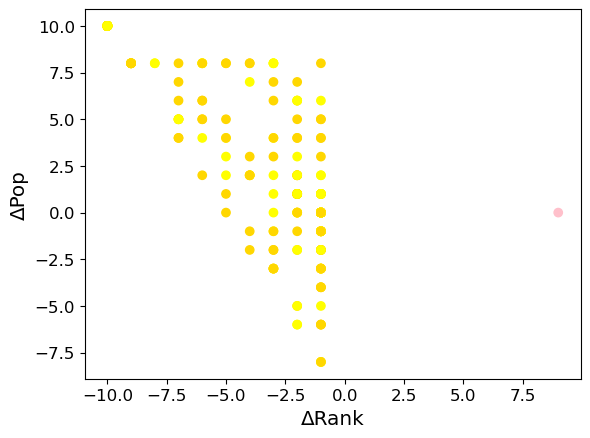

In [375]:
plt.scatter(d_rank, d_pop, color = [marker_dict[x] for x in color])
plt.xlabel(f"ΔRank")
plt.ylabel(f"ΔPop")

/var/folders/wp/n1skbfwj5pj_dx8ylpgzwb080000gn/T/ipykernel_2063/3971903192.py:4: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=np.asarray(d_rank)[sel],y=np.asarray(d_pop)[sel], levels=5, cut = 0.5, \


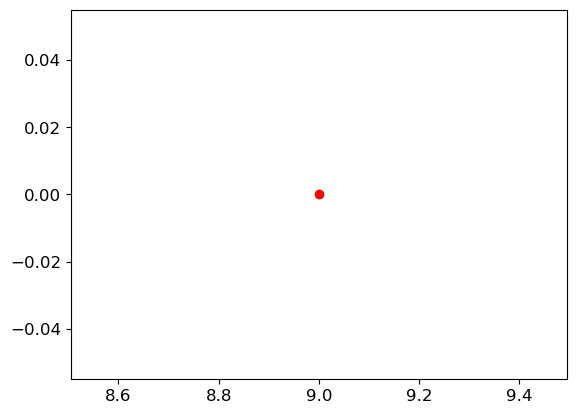

In [389]:
# for i, col in enumerate([(1, 0), (1, 1), (2, 0)]):
col = (1, 1)
sel = np.where(np.all(np.asarray(color) == col, axis=1))
sns.kdeplot(x=np.asarray(d_rank)[sel],y=np.asarray(d_pop)[sel], levels=5, cut = 0.5, \
            bw_adjust=0.4)

plt.scatter(x=np.asarray(d_rank)[sel],y=np.asarray(d_pop)[sel], color='red', label='Data Point')


/var/folders/wp/n1skbfwj5pj_dx8ylpgzwb080000gn/T/ipykernel_2063/3956764753.py:24: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=np.asarray(d_rank)[sel],y=np.asarray(d_pop)[sel], levels=5, cut = 0.5, \


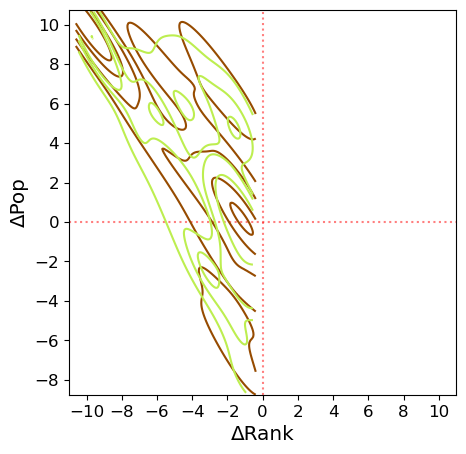

In [370]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
kde_subplot(ax, d_rank, d_pop, color)

In [371]:
d_pop, d_rank, color = [], [], []
out_path = "./docking_poses/DiffDock-S/self_cross_dock/"

df_S = df_S.loc[df_S.PDB_chain.isin(ro_ts_pca.PDB_chain)].reset_index(drop=True)
df_S_crd = df_S[~df_S.PDB_chain_LIG.isin(sd_cdk2.PDB_chain_LIG)]

for name, lr_label in \
    zip(df_S_crd.drop_duplicates(["ind", "PDB_chain_LIG"]).name,\
        df_S_crd.drop_duplicates(["ind", "PDB_chain_LIG"]).lig_lr_label):
    lig_fns = sorted(glob(f'{out_path}/{name}_*.pdb'), \
                     key=lambda x: -float(os.path.basename(x).strip('.pdb').split('/')[-1].split('_')[4]))
    cent_dist = df_S_crd[df_S_crd.name==name].cent_dist.to_list()

    if any([x < 5.0 for x in cent_dist]):
        r, p = get_crossdocking_bias(lig_fns, df_S_crd[df_S_crd.name==name], cent_dist, lt=5, mol1_type = "dd_pdb", mol2_type = "dd_pdb")
        d_pop.append(p)
        d_rank.append(r)
        color.append(lr_label)


{1: [1, 3, 4], 2: [2], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 3], 4: [4, 10], 5: [5, 6, 7, 9], 8: [8]}
{1: [1], 2: [2], 3: [3, 7], 4: [4], 5: [5], 6: [6], 8: [8], 9: [9, 10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9], 10: [10]}
{1: [1, 3, 4, 5, 6, 7, 8, 9, 10], 2: [2]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 3, 4, 5, 7], 6: [6, 8, 9, 10]}
{1: [1, 3, 4, 9], 2: [2, 5, 6, 7, 8, 10]}
{1: [1], 2: [2], 3: [3, 4, 5, 7], 6: [6, 8, 9, 10]}
{1: [1, 5, 9, 10], 2: [2, 3, 4, 6, 7, 8]}
{1: [1, 2, 4, 7], 3: [3, 5, 6, 8], 9: [9], 10: [10]}
{1: [1, 2, 4, 8], 3: [3, 6, 7], 5: [5, 10], 9: [9]}


[18:03:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:27] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:27] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:27] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:27] Explicit valence for atom # 30 C, 5, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_1_2.1_1.1.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_10_1.7_-3.4.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_2_1.8_0.5.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_10_1.7_-3.4.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_3_3.5_0.1.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_10_1.7_-3.4.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_5_1.6_-1.8.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_10_1.7_-3.4.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_6_1.8_-2.0.pdb:6, ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_10_1.7_-3.4.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_7_1.7_-2.3.pdb:7, ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_10_1.7_-3.4.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_9_1.8_-3.1.pdb:8, ./docking_poses/DiffDock-S

[18:03:28] Problem with coordinates for PDB atom #1
[18:03:28] Problem with coordinates for PDB atom #1
[18:03:28] Problem with coordinates for PDB atom #1
[18:03:28] Problem with coordinates for PDB atom #1


skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-2PU_1_7.8_-4.3.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-2PU_10_inf_-1000.0.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-2PU_6_3.3_-5.2.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-2PU_10_inf_-1000.0.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-2PU_5_3.0_-5.2.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-2PU_10_inf_-1000.0.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-2PU_3_7.6_-5.2.pdb:6, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-2PU_10_inf_-1000.0.pdb:10
{1: [1, 2], 3: [3, 5, 7, 8, 9], 4: [4], 6: [6], 10: [10]}
{1: [1, 2, 3, 5, 6, 7, 8, 9, 10], 4: [4]}
{1: [1, 2, 4, 5, 6, 7, 8, 9], 3: [3], 10: [10]}
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-ATP_1_1.8_-4.8.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-ATP_4_1.6_-5.2.pdb:3
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-ATP_2_1.9_-5.0.pdb:2, ./docking_poses

[18:03:28] Explicit valence for atom # 22 O, 3, is greater than permitted
[18:03:28] Explicit valence for atom # 22 O, 3, is greater than permitted
[18:03:28] Explicit valence for atom # 22 O, 3, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-ATP_4_1.6_-5.2.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-ATP_10_1.8_-7.5.pdb:5
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 3, 4, 5, 7, 8, 10], 6: [6, 9]}
{1: [1, 2, 3, 4, 5, 6, 7, 9], 8: [8, 10]}
{1: [1], 2: [2, 3], 4: [4, 5, 6, 7], 8: [8], 9: [9], 10: [10]}
{1: [1, 4], 2: [2, 3], 5: [5, 6, 7, 9], 8: [8, 10]}
{1: [1, 2, 3, 4, 6, 7, 8], 5: [5], 9: [9], 10: [10]}
{1: [1], 2: [2], 3: [3, 4], 5: [5, 8, 9], 6: [6], 7: [7], 10: [10]}
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_1_2.4_1.2.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_2_2.3_0.1.pdb:2
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_1_2.4_1.2.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_3_2.4_0.0.pdb:3
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_1_2.4_1.2.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_4_2.0_-0.3.pdb:4
skip ./docking

[18:03:30] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:30] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:30] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:30] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:30] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:31] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:31] Explicit valence for atom # 30 C, 5, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_1_2.4_1.2.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_5_1.9_-0.6.pdb:5
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_4_2.0_-0.3.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_5_1.9_-0.6.pdb:5
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_1_2.4_1.2.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_7_2.5_-0.8.pdb:6
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_4_2.0_-0.3.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_7_2.5_-0.8.pdb:6
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_1_2.4_1.2.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_6_2.1_-0.8.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_4_2.0_-0.3.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_6_2.1_-0.8.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_1_2.4_1.2.pdb:1, ./docking_poses/DiffDock-S/self_cross_d

[18:03:31] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:31] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:31] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:31] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:31] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:31] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:31] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:31] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:31] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:31] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:31] Explicit valence for atom # 30 C, 5, is greater than permitted


{1: [1, 2, 6], 3: [3], 4: [4], 5: [5], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1], 2: [2], 3: [3], 4: [4, 8, 9], 5: [5], 6: [6], 7: [7], 10: [10]}
{1: [1], 2: [2, 3, 4, 5, 6, 7], 8: [8, 9], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 8, 9, 10], 7: [7]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 3], 2: [2, 6, 7, 9], 4: [4, 8], 5: [5], 10: [10]}
{1: [1, 2, 3, 4, 8], 5: [5, 6, 7, 9, 10]}
{1: [1, 2, 3], 4: [4], 5: [5], 6: [6, 7], 8: [8], 9: [9], 10: [10]}
{1: [1], 2: [2, 3, 4, 5, 6, 7], 8: [8, 10], 9: [9]}
{1: [1, 2, 3, 4, 6, 8], 5: [5, 7, 9], 10: [10]}
{1: [1, 3, 5], 2: [2, 4], 6: [6, 7, 9], 8: [8, 10]}
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_1_2.1_0.8.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_2_2.0_0.7.pdb:2
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_1_2.1_0.8.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_3_2.0_0.6.pdb:3
skip ./docking_poses/DiffDock-S/

[18:03:35] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:35] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:35] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:35] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:35] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:35] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:36] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:03:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:36] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:03:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:36] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:03:36] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:03:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:36] Explicit valence for atom # 30 

skip ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_2_2.0_0.7.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_7_2.0_-0.1.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_3_2.0_0.6.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_7_2.0_-0.1.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_5_2.8_0.4.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_7_2.0_-0.1.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_2_2.0_0.7.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_9_1.9_-0.2.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_3_2.0_0.6.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_9_1.9_-0.2.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_5_2.8_0.4.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_9_1.9_-0.2.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_2_2.0_0.7.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock

[18:03:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:36] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:03:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:36] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:03:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:36] Explicit valence for atom # 2 C, 5, is greater than permitted


{1: [1], 2: [2], 3: [3, 5, 6], 4: [4], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1], 2: [2], 3: [3, 6], 4: [4, 5], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 7], 3: [3], 4: [4, 5, 6, 9, 10], 8: [8]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5, 6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8], 9: [9], 10: [10]}
{1: [1, 2, 4, 5, 6, 8, 10], 3: [3], 7: [7, 9]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 5, 6, 7, 9], 3: [3, 4, 8, 10]}
{1: [1, 2, 3, 4, 7, 8, 10], 5: [5, 6], 9: [9]}
{1: [1], 2: [2, 3, 4, 5], 6: [6, 7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 3], 4: [4], 5: [5], 6: [6, 7], 8: [8, 10], 9: [9]}
{1: [1], 2: [2, 3, 5, 9, 10], 4: [4, 8], 6: [6], 7: [7]}
{1: [1], 2: [2, 3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_1_1.2_3.5.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_5_1.4_2.8.pdb:5
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_2_1.6_3.3.pdb:2, ./docking_poses/DiffD

[18:03:39] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:40] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:40] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:40] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:40] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:40] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:40] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:40] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:40] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:40] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:40] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:40] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:40] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:40] Explicit valence for atom #

skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_5_1.4_2.8.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_6_3.0_2.1.pdb:6
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_5_1.4_2.8.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_7_3.0_2.0.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_5_1.4_2.8.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_8_1.7_1.4.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_1_1.2_3.5.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_9_3.0_0.4.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_2_1.6_3.3.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_9_3.0_0.4.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_3_1.3_3.0.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_9_3.0_0.4.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_4_1.5_3.0.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/1JST_

[18:03:40] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:40] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:40] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:40] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:40] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:40] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:40] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:40] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:40] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:40] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:40] Explicit valence for atom # 30 C, 5, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_8_1.7_1.4.pdb:8, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_10_3.1_0.2.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_9_3.0_0.4.pdb:9, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_10_3.1_0.2.pdb:10
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5, 7], 6: [6], 8: [8], 9: [9], 10: [10]}
{1: [1, 4], 2: [2], 3: [3], 5: [5], 6: [6, 7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 6, 7, 8], 3: [3, 4, 5, 10], 9: [9]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7], 8: [8, 10], 9: [9]}
{1: [1, 2, 3, 4, 5, 6, 10], 7: [7, 8, 9]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5]}
{1: [1, 2, 4], 3: [3, 5, 6], 7: [7, 8, 9], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 3, 4, 5, 6], 7: [7, 8, 9], 10: [10]}
{1: [1, 2, 3, 4], 5: [5, 6], 7: [7, 8, 9], 10: [10]}
{1: [1], 2: [2, 4],

[18:03:53] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:53] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:53] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:53] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:53] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:53] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:53] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:53] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:53] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:53] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:53] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:53] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:53] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:03:53] Explicit valence for atom #

skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_6_1.9_-4.3.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_5_2.3_-4.3.pdb:6
skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_1_2.0_-2.8.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_7_1.9_-4.4.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_2_2.0_-2.9.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_7_1.9_-4.4.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_3_1.8_-3.9.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_7_1.9_-4.4.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_6_1.9_-4.3.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_7_1.9_-4.4.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_5_2.3_-4.3.pdb:6, ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_7_1.9_-4.4.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_6_1.9_-4.3.pdb:5, ./docking_poses/DiffDock-S/self_cro

[18:03:53] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:03:53] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:03:53] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:03:53] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:03:53] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:03:53] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:03:53] Explicit valence for atom # 9 O, 3, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-WG1_1_2.1_-2.8.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-WG1_3_2.1_-3.0.pdb:4
skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-WG1_4_2.1_-3.0.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-WG1_3_2.1_-3.0.pdb:4
skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-WG1_3_2.1_-3.0.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-WG1_6_2.6_-3.4.pdb:6
skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-WG1_3_2.1_-3.0.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-WG1_7_2.1_-3.5.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-WG1_3_2.1_-3.0.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-WG1_8_2.4_-3.8.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-WG1_3_2.1_-3.0.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-WG1_9_2.4_-3.8.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-WG1_3_2.1_-3.0.pdb:4, ./docking_poses/DiffDock-S/self_cro

[18:04:04] Explicit valence for atom # 19 O, 3, is greater than permitted
[18:04:04] Explicit valence for atom # 19 O, 3, is greater than permitted
[18:04:04] Explicit valence for atom # 19 O, 3, is greater than permitted
[18:04:05] Explicit valence for atom # 19 O, 3, is greater than permitted
[18:04:05] Explicit valence for atom # 19 O, 3, is greater than permitted
[18:04:05] Explicit valence for atom # 19 O, 3, is greater than permitted
[18:04:05] Explicit valence for atom # 19 O, 3, is greater than permitted
[18:04:05] Explicit valence for atom # 19 O, 3, is greater than permitted
[18:04:05] Explicit valence for atom # 19 O, 3, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-T7Z_2_1.7_1.2.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-T7Z_6_1.5_-1.0.pdb:6
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-T7Z_1_1.6_1.2.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-T7Z_6_1.5_-1.0.pdb:6
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-T7Z_3_1.9_1.0.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-T7Z_6_1.5_-1.0.pdb:6
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-T7Z_4_2.2_0.1.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-T7Z_6_1.5_-1.0.pdb:6
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-T7Z_5_3.2_0.0.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-T7Z_6_1.5_-1.0.pdb:6
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-T7Z_6_1.5_-1.0.pdb:6, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-T7Z_7_1.4_-1.0.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-T7Z_6_1.5_-1.0.pdb:6, ./docking_poses/DiffDock-S/self_cross_do

[18:04:05] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:05] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:05] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:05] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:05] Explicit valence for atom # 9 O, 3, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_1_1.5_-1.6.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_3_2.0_-2.2.pdb:3
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_2_2.0_-2.0.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_3_2.0_-2.2.pdb:3
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_3_2.0_-2.2.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_4_1.4_-2.4.pdb:4
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_3_2.0_-2.2.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_6_1.6_-2.7.pdb:5
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_3_2.0_-2.2.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_5_1.5_-2.7.pdb:6


[18:04:05] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:05] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:05] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:05] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:05] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:05] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:05] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:05] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:05] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:05] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:05] Explicit valence for atom # 9 O, 3, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_1_1.5_-1.6.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_8_1.8_-3.0.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_2_2.0_-2.0.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_8_1.8_-3.0.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_3_2.0_-2.2.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_8_1.8_-3.0.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_4_1.4_-2.4.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_8_1.8_-3.0.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_6_1.6_-2.7.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_8_1.8_-3.0.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_5_1.5_-2.7.pdb:6, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_8_1.8_-3.0.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_3_2.0_-2.2.pdb:3, ./docking_poses/DiffDock-S/self_cro

[18:04:08] Problem with coordinates for PDB atom #1
[18:04:08] Problem with coordinates for PDB atom #1


skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-CK4_1_0.5_1.0.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-CK4_10_inf_-1000.0.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-CK4_4_0.6_0.5.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-CK4_10_inf_-1000.0.pdb:10
{1: [1, 2, 4, 5, 6, 8, 9], 3: [3, 7], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1], 2: [2, 3], 4: [4, 5, 6, 8], 7: [7, 9], 10: [10]}
{1: [1, 2, 5, 6, 7, 8], 3: [3], 4: [4], 9: [9, 10]}


[18:04:09] Problem with coordinates for PDB atom #1
[18:04:09] Problem with coordinates for PDB atom #1
[18:04:09] Problem with coordinates for PDB atom #1
[18:04:09] Problem with coordinates for PDB atom #1
[18:04:09] Problem with coordinates for PDB atom #1
[18:04:09] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:09] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:09] Explicit valence for atom # 30 C, 5, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-SQ9_1_1.2_-4.2.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-SQ9_10_inf_-1000.0.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-SQ9_2_1.1_-4.3.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-SQ9_10_inf_-1000.0.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-SQ9_3_1.0_-4.4.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-SQ9_10_inf_-1000.0.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-SQ9_4_1.3_-4.4.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-SQ9_10_inf_-1000.0.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-SQ9_8_7.6_-4.9.pdb:8, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-SQ9_10_inf_-1000.0.pdb:10
{1: [1, 5], 2: [2, 7], 3: [3], 4: [4, 6], 8: [8, 9], 10: [10]}
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_1_3.8_3.6.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_4_2.1_0.8.pdb:4
skip ./docking_poses/DiffD

[18:04:09] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:09] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:09] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:09] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:09] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:09] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:09] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:09] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:09] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:09] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:09] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:09] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:09] Explicit valence for atom # 30 C, 5, is greater than permitted


{1: [1], 2: [2, 4], 3: [3], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1], 2: [2, 5], 3: [3, 4, 6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 5], 2: [2, 6, 8, 10], 3: [3, 4, 7, 9]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 4, 5, 6, 7, 8, 9, 10], 3: [3]}
{1: [1, 2], 3: [3], 4: [4], 5: [5, 6, 7, 8, 10], 9: [9]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1], 2: [2, 3, 4, 5, 6, 10], 7: [7, 8, 9]}
{1: [1, 3, 5, 6, 7, 8, 9, 10], 2: [2, 4]}
{1: [1, 2], 3: [3], 4: [4], 5: [5, 6], 7: [7, 8, 9, 10]}
{1: [1, 2, 3, 5, 7], 4: [4], 6: [6, 8, 9], 10: [10]}
{1: [1, 3, 7, 8, 10], 2: [2, 4, 5, 6, 9]}
{1: [1], 2: [2, 4, 7], 3: [3], 5: [5], 6: [6], 8: [8], 9: [9, 10]}


[18:04:14] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:14] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:14] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:14] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:14] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:14] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:14] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:14] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:14] Explicit valence for atom # 30 C, 5, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-T7Z_1_2.6_-4.2.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-T7Z_6_3.1_-4.9.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-T7Z_1_2.7_-4.5.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-T7Z_6_3.1_-4.9.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-T7Z_2_2.7_-4.6.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-T7Z_6_3.1_-4.9.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-T7Z_3_2.7_-4.8.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-T7Z_6_3.1_-4.9.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-T7Z_2_3.2_-4.8.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-T7Z_6_3.1_-4.9.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-T7Z_3_3.0_-4.8.pdb:6, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-T7Z_6_3.1_-4.9.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-T7Z_4_2.9_-4.8.pdb:7, ./docking_poses/DiffDock-S/self_cro

[18:04:15] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:15] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:15] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:15] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:15] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:15] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:15] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:15] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:15] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:15] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:15] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:15] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:15] Explicit valence for atom # 9 O, 3, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_1_2.3_-4.8.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_1_2.7_-4.9.pdb:2
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_1_2.7_-4.9.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_3_2.3_-5.0.pdb:3
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_1_2.7_-4.9.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_4_2.3_-5.0.pdb:4
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_1_2.7_-4.9.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_5_2.3_-5.0.pdb:5
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_1_2.7_-4.9.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_2_2.3_-5.0.pdb:6
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_1_2.3_-4.8.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_3_2.7_-5.0.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_1_2.7_-4.9.pdb:2, ./docking_poses/DiffDock-S/self_cro

[18:04:15] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:15] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:15] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:15] Explicit valence for atom # 9 O, 3, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_1_2.7_-4.9.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_2_2.7_-5.0.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_3_2.7_-5.0.pdb:7, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_2_2.7_-5.0.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_1_2.7_-4.9.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_5_2.8_-5.1.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_3_2.7_-5.0.pdb:7, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_5_2.8_-5.1.pdb:10
{1: [1], 2: [2], 3: [3], 4: [4, 6], 5: [5], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2], 3: [3], 4: [4, 6], 5: [5, 7], 8: [8], 9: [9], 10: [10]}
{1: [1, 3, 5, 6], 2: [2, 4, 8], 7: [7, 10], 9: [9]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9], 10: [10]}
{1: [1, 2], 3: [3, 4, 5, 9, 10], 6: [6, 7, 8]}
{1: [1], 2: [2], 3: [3], 4: [4], 5:

[18:04:19] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:04:19] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:04:19] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:04:19] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:04:19] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:04:20] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:04:20] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:20] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:20] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:20] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:20] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:04:20] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:20] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:20] Explicit valence for atom # 30 C, 

skip ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_3_3.7_-3.3.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_4_3.1_-3.5.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_1_3.6_-2.5.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_3_3.1_-3.5.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_1_3.7_-2.7.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_3_3.1_-3.5.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_2_3.0_-2.7.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_3_3.1_-3.5.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_2_3.3_-3.1.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_3_3.1_-3.5.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_3_3.7_-3.3.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_3_3.1_-3.5.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_4_3.9_-3.4.pdb:6, ./docking_poses/DiffDock-S/self_cro

[18:04:20] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:04:20] Explicit valence for atom # 30 C, 5, is greater than permitted


{1: [1, 3], 2: [2], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1], 2: [2, 7, 8], 3: [3, 6], 4: [4], 5: [5], 9: [9], 10: [10]}
{1: [1, 2, 3, 5, 6], 4: [4], 7: [7, 9], 8: [8], 10: [10]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 4, 5, 6, 7, 9, 10], 3: [3, 8]}
{1: [1, 2, 3, 4, 5, 6, 7], 8: [8, 9, 10]}
{1: [1], 2: [2], 3: [3], 4: [4, 4], 5: [5]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9], 10: [10]}
{1: [1, 2, 4, 5, 6, 7, 9, 10], 3: [3, 8]}
{1: [1], 2: [2, 3], 4: [4], 5: [5, 6], 7: [7], 8: [8, 9], 10: [10]}
{1: [1], 2: [2, 3, 4, 5, 6], 7: [7], 8: [8], 9: [9, 10]}
{1: [1, 3, 5], 2: [2, 4], 6: [6, 7, 8], 9: [9, 10]}
{1: [1], 2: [2, 4, 6, 8], 3: [3], 5: [5], 7: [7], 9: [9], 10: [10]}


[18:04:25] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:25] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:25] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:25] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:25] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:25] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:25] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:25] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:25] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:25] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:25] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:25] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:25] Explicit valence for atom # 9 O, 3, is greater than permitted
[18:04:25] Explicit valence for atom # 9 O, 3, is g

skip ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_1_1.7_3.9.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_9_1.9_2.6.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_3_1.6_3.5.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_9_1.9_2.6.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_2_1.6_3.5.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_9_1.9_2.6.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_4_1.8_3.4.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_9_1.9_2.6.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_5_1.7_3.4.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_9_1.9_2.6.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_6_1.8_3.3.pdb:6, ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_9_1.9_2.6.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_1_1.7_3.9.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/4BCM_

[18:04:29] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:29] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:29] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:29] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:29] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:29] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:29] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:30] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:30] Explicit valence for atom # 30 C, 5, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/4CFW_C-T7Z_1_3.4_4.0.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/4CFW_C-T7Z_10_1.3_-0.6.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/4CFW_C-T7Z_2_3.4_3.8.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/4CFW_C-T7Z_10_1.3_-0.6.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/4CFW_C-T7Z_3_1.8_2.6.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/4CFW_C-T7Z_10_1.3_-0.6.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/4CFW_C-T7Z_4_1.6_2.0.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/4CFW_C-T7Z_10_1.3_-0.6.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/4CFW_C-T7Z_5_1.4_1.8.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/4CFW_C-T7Z_10_1.3_-0.6.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/4CFW_C-T7Z_7_1.2_1.3.pdb:6, ./docking_poses/DiffDock-S/self_cross_dock/4CFW_C-T7Z_10_1.3_-0.6.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/4CFW_C-T7Z_6_1.3_1.3.pdb:7, ./docking_poses/DiffDock-S/sel

[18:04:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:47] Explicit valence for atom # 30 C, 5, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_3_1.5_1.8.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_7_1.4_0.5.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_4_1.6_1.3.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_7_1.4_0.5.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_6_1.7_0.8.pdb:6, ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_7_1.4_0.5.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_1_3.0_3.5.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_8_1.7_0.5.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_1_3.0_3.5.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_9_1.7_-0.8.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_7_1.4_0.5.pdb:7, ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_9_1.7_-0.8.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_1_3.0_3.5.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/7KJ

[18:04:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:04:47] Explicit valence for atom # 30 C, 5, is greater than permitted


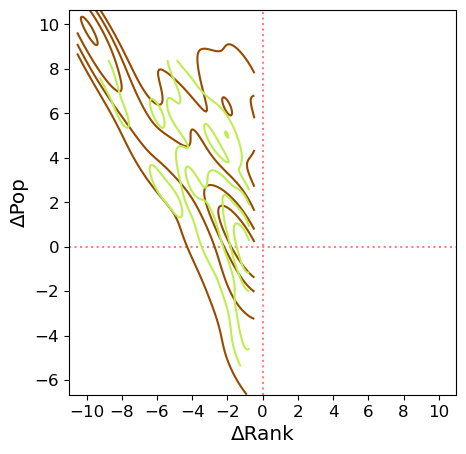

In [372]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
kde_subplot(ax, d_rank, d_pop, color)

In [ ]:
d_pop, d_rank, color = [], [], []
out_path = "./docking_poses/DiffDock-S/self_cross_dock/"

df_S = df_S.loc[df_S.PDB_chain.isin(ro_ts_pca.PDB_chain)].reset_index(drop=True)
df_S_crd = df_S[~df_S.PDB_chain_LIG.isin(sd_cdk2.PDB_chain_LIG)]

for name, lr_label in \
    zip(df_S_crd.drop_duplicates(["ind", "PDB_chain_LIG"]).name,\
        df_S_crd.drop_duplicates(["ind", "PDB_chain_LIG"]).lig_lr_label):
    lig_fns = sorted(glob(f'{out_path}/{name}_*.pdb'), \
                     key=lambda x: -float(os.path.basename(x).strip('.pdb').split('/')[-1].split('_')[4]))
    cent_dist = df_S_crd[df_S_crd.name==name].cent_dist.to_list()

    if any([x < 5.0 for x in cent_dist]):
        r, p = get_crossdocking_bias(lig_fns, df_S_crd[df_S_crd.name==name], cent_dist, lt=5, mol1_type = "dd_pdb", mol2_type = "dd_pdb")
        d_pop.append(p)
        d_rank.append(r)
        color.append(lr_label)


{1: [1, 3, 4], 2: [2], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 3], 4: [4, 10], 5: [5, 6, 7, 9], 8: [8]}
{1: [1], 2: [2], 3: [3, 7], 4: [4], 5: [5], 6: [6], 8: [8], 9: [9, 10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9], 10: [10]}
{1: [1, 3, 4, 5, 6, 7, 8, 9, 10], 2: [2]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 3, 4, 5, 7], 6: [6, 8, 9, 10]}
{1: [1, 3, 4, 9], 2: [2, 5, 6, 7, 8, 10]}
{1: [1], 2: [2], 3: [3, 4, 5, 7], 6: [6, 8, 9, 10]}
{1: [1, 5, 9, 10], 2: [2, 3, 4, 6, 7, 8]}
{1: [1, 2, 4, 7], 3: [3, 5, 6, 8], 9: [9], 10: [10]}
{1: [1, 2, 4, 8], 3: [3, 6, 7], 5: [5, 10], 9: [9]}


[16:50:15] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:15] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:15] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:15] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:15] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:15] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:15] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:15] Explicit valence for atom # 30 C, 5, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_1_2.1_1.1.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_10_1.7_-3.4.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_2_1.8_0.5.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_10_1.7_-3.4.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_3_3.5_0.1.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_10_1.7_-3.4.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_5_1.6_-1.8.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_10_1.7_-3.4.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_6_1.8_-2.0.pdb:6, ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_10_1.7_-3.4.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_7_1.7_-2.3.pdb:7, ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_10_1.7_-3.4.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/1B38_A-T7Z_9_1.8_-3.1.pdb:8, ./docking_poses/DiffDock-S

[16:50:16] Problem with coordinates for PDB atom #1
[16:50:16] Problem with coordinates for PDB atom #1
[16:50:16] Problem with coordinates for PDB atom #1
[16:50:16] Problem with coordinates for PDB atom #1


skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-2PU_1_7.8_-4.3.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-2PU_10_inf_-1000.0.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-2PU_6_3.3_-5.2.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-2PU_10_inf_-1000.0.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-2PU_5_3.0_-5.2.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-2PU_10_inf_-1000.0.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-2PU_3_7.6_-5.2.pdb:6, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-2PU_10_inf_-1000.0.pdb:10
{1: [1, 2], 3: [3, 5, 7, 8, 9], 4: [4], 6: [6], 10: [10]}
{1: [1, 2, 3, 5, 6, 7, 8, 9, 10], 4: [4]}
{1: [1, 2, 4, 5, 6, 7, 8, 9], 3: [3], 10: [10]}
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-ATP_1_1.8_-4.8.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-ATP_4_1.6_-5.2.pdb:3
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-ATP_2_1.9_-5.0.pdb:2, ./docking_poses

[16:50:17] Explicit valence for atom # 22 O, 3, is greater than permitted
[16:50:17] Explicit valence for atom # 22 O, 3, is greater than permitted
[16:50:17] Explicit valence for atom # 22 O, 3, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-ATP_4_1.6_-5.2.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-ATP_10_1.8_-7.5.pdb:5
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 3, 4, 5, 7, 8, 10], 6: [6, 9]}
{1: [1, 2, 3, 4, 5, 6, 7, 9], 8: [8, 10]}
{1: [1], 2: [2, 3], 4: [4, 5, 6, 7], 8: [8], 9: [9], 10: [10]}
{1: [1, 4], 2: [2, 3], 5: [5, 6, 7, 9], 8: [8, 10]}
{1: [1, 2, 3, 4, 6, 7, 8], 5: [5], 9: [9], 10: [10]}
{1: [1], 2: [2], 3: [3, 4], 5: [5, 8, 9], 6: [6], 7: [7], 10: [10]}
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_1_2.4_1.2.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_2_2.3_0.1.pdb:2
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_1_2.4_1.2.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_3_2.4_0.0.pdb:3
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_1_2.4_1.2.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_4_2.0_-0.3.pdb:4
skip ./docking

[16:50:18] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:18] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:18] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:18] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:19] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:19] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:19] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:19] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:19] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:19] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:19] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:19] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:19] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:19] Explicit valence for atom #

skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_1_2.4_1.2.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_9_2.0_-1.3.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_4_2.0_-0.3.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_9_2.0_-1.3.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_1_2.4_1.2.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_10_2.5_-1.5.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_4_2.0_-0.3.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/1GIH_A-T7Z_10_2.5_-1.5.pdb:10
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}


[16:50:19] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:19] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:19] Explicit valence for atom # 30 C, 5, is greater than permitted


{1: [1, 2, 6], 3: [3], 4: [4], 5: [5], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1], 2: [2], 3: [3], 4: [4, 8, 9], 5: [5], 6: [6], 7: [7], 10: [10]}
{1: [1], 2: [2, 3, 4, 5, 6, 7], 8: [8, 9], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 8, 9, 10], 7: [7]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 3], 2: [2, 6, 7, 9], 4: [4, 8], 5: [5], 10: [10]}
{1: [1, 2, 3, 4, 8], 5: [5, 6, 7, 9, 10]}
{1: [1, 2, 3], 4: [4], 5: [5], 6: [6, 7], 8: [8], 9: [9], 10: [10]}
{1: [1], 2: [2, 3, 4, 5, 6, 7], 8: [8, 10], 9: [9]}
{1: [1, 2, 3, 4, 6, 8], 5: [5, 7, 9], 10: [10]}
{1: [1, 3, 5], 2: [2, 4], 6: [6, 7, 9], 8: [8, 10]}
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_1_2.1_0.8.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_2_2.0_0.7.pdb:2
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_1_2.1_0.8.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_3_2.0_0.6.pdb:3
skip ./docking_poses/DiffDock-S/

[16:50:22] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 30 

skip ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_3_2.0_0.6.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_7_2.0_-0.1.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_5_2.8_0.4.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_7_2.0_-0.1.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_2_2.0_0.7.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_9_1.9_-0.2.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_3_2.0_0.6.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_9_1.9_-0.2.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_5_2.8_0.4.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_9_1.9_-0.2.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_2_2.0_0.7.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_8_2.0_-0.2.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/1GIJ_A-T7Z_3_2.0_0.6.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock

[16:50:22] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:22] Explicit valence for atom # 2 C, 5, is greater than permitted


{1: [1], 2: [2], 3: [3, 5, 6], 4: [4], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1], 2: [2], 3: [3, 6], 4: [4, 5], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 7], 3: [3], 4: [4, 5, 6, 9, 10], 8: [8]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5, 6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8], 9: [9], 10: [10]}
{1: [1, 2, 4, 5, 6, 8, 10], 3: [3], 7: [7, 9]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 5, 6, 7, 9], 3: [3, 4, 8, 10]}
{1: [1, 2, 3, 4, 7, 8, 10], 5: [5, 6], 9: [9]}
{1: [1], 2: [2, 3, 4, 5], 6: [6, 7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 3], 4: [4], 5: [5], 6: [6, 7], 8: [8, 10], 9: [9]}
{1: [1], 2: [2, 3, 5, 9, 10], 4: [4, 8], 6: [6], 7: [7]}
{1: [1], 2: [2, 3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}


[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_1_1.2_3.5.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_5_1.4_2.8.pdb:5
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_2_1.6_3.3.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_5_1.4_2.8.pdb:5
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_3_1.3_3.0.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_5_1.4_2.8.pdb:5
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_4_1.5_3.0.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_5_1.4_2.8.pdb:5
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_5_1.4_2.8.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_6_3.0_2.1.pdb:6
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_5_1.4_2.8.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_7_3.0_2.0.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_5_1.4_2.8.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/1JST_

[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:26] Explicit valence for atom #

skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_1_1.2_3.5.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_9_3.0_0.4.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_2_1.6_3.3.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_9_3.0_0.4.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_3_1.3_3.0.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_9_3.0_0.4.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_4_1.5_3.0.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_9_3.0_0.4.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_5_1.4_2.8.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_9_3.0_0.4.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_6_3.0_2.1.pdb:6, ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_9_3.0_0.4.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/1JST_A-T7Z_7_3.0_2.0.pdb:7, ./docking_poses/DiffDock-S/self_cross_dock/1JST_

[16:50:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:36] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:36] Explicit valence for atom #

skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_6_1.9_-4.3.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_9_2.2_-4.5.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_7_1.9_-4.4.pdb:7, ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_9_2.2_-4.5.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_6_1.9_-4.3.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_8_1.8_-4.5.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_7_1.9_-4.4.pdb:7, ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_8_1.8_-4.5.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_6_1.9_-4.3.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_10_2.3_-4.7.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_7_1.9_-4.4.pdb:7, ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-T7Z_10_2.3_-4.7.pdb:10
{1: [1], 2: [2], 3: [3, 4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
skip ./docking_poses/DiffDock-

[16:50:36] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:36] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:36] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:36] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:36] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:36] Explicit valence for atom # 9 O, 3, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-WG1_3_2.1_-3.0.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-WG1_8_2.4_-3.8.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-WG1_3_2.1_-3.0.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-WG1_9_2.4_-3.8.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-WG1_3_2.1_-3.0.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/2R3R_A-WG1_10_2.4_-4.6.pdb:10
{1: [1, 2, 5], 3: [3], 4: [4], 6: [6], 7: [7], 8: [8], 9: [9, 10]}


[16:50:36] Explicit valence for atom # 9 O, 3, is greater than permitted


{1: [1, 7, 9], 2: [2], 3: [3, 5], 4: [4], 6: [6], 8: [8], 10: [10]}
{1: [1, 2], 3: [3], 4: [4, 5, 6, 7, 9, 10], 8: [8]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9], 10: [10]}
{1: [1, 2, 3, 6, 7], 4: [4, 5], 8: [8, 9, 10]}
{1: [1, 2], 3: [3], 4: [4, 5, 6, 7, 8], 9: [9, 10]}
{1: [1, 3], 2: [2], 4: [4], 5: [5, 6, 8], 7: [7, 9, 10]}
{1: [1, 2, 6, 8, 9, 10], 3: [3, 4, 5, 7]}
{1: [1], 2: [2, 4, 5, 8], 3: [3], 6: [6], 7: [7], 9: [9], 10: [10]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 5], 2: [2, 9], 3: [3], 4: [4], 6: [6], 7: [7], 8: [8], 10: [10]}
{1: [1, 3], 2: [2], 4: [4, 5, 6, 8], 7: [7], 9: [9], 10: [10]}
{1: [1, 2], 3: [3], 4: [4, 5, 6], 7: [7, 9], 8: [8], 10: [10]}
{1: [1], 2: [2], 3: [3], 4: [4, 6], 5: [5], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1,

[16:50:41] Explicit valence for atom # 19 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 19 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 19 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 19 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 19 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 19 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 19 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 19 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 19 O, 3, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-T7Z_6_1.5_-1.0.pdb:6, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-T7Z_10_1.4_-3.1.pdb:10
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7, 9], 8: [8], 10: [10]}
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_1_1.5_-1.6.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_3_2.0_-2.2.pdb:3
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_2_2.0_-2.0.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_3_2.0_-2.2.pdb:3
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_3_2.0_-2.2.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_4_1.4_-2.4.pdb:4
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_3_2.0_-2.2.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_6_1.6_-2.7.pdb:5


[16:50:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 9 O, 3, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_3_2.0_-2.2.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_5_1.5_-2.7.pdb:6
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_1_1.5_-1.6.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_8_1.8_-3.0.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_2_2.0_-2.0.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_8_1.8_-3.0.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_3_2.0_-2.2.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_8_1.8_-3.0.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_4_1.4_-2.4.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_8_1.8_-3.0.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_6_1.6_-2.7.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_8_1.8_-3.0.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHT_A-WG1_5_1.5_-2.7.pdb:6, ./docking_poses/DiffDock-S/self_cro

[16:50:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:42] Explicit valence for atom # 9 O, 3, is greater than permitted


{1: [1, 7], 2: [2], 3: [3, 8], 4: [4, 5], 6: [6], 9: [9], 10: [10]}
{1: [1, 2, 3], 4: [4, 5, 6, 9], 7: [7], 8: [8, 10]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7, 10], 8: [8], 9: [9]}
{1: [1, 2, 3, 4, 6, 7, 8], 5: [5, 9, 10]}
{1: [1, 2, 3, 4, 5, 6], 7: [7, 9, 10], 8: [8]}
{1: [1], 2: [2, 3], 3: [3], 4: [4], 5: [5]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-CK4_1_0.5_1.0.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-CK4_10_inf_-1000.0.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-CK4_4_0.6_0.5.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-CK4_10_inf_-1000.0.pdb:10
{1: [1, 2, 4, 5, 6, 8, 9], 3: [3, 7], 10: [10]}


[16:50:43] Problem with coordinates for PDB atom #1
[16:50:43] Problem with coordinates for PDB atom #1


{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1], 2: [2, 3], 4: [4, 5, 6, 8], 7: [7, 9], 10: [10]}
{1: [1, 2, 5, 6, 7, 8], 3: [3], 4: [4], 9: [9, 10]}


[16:50:44] Problem with coordinates for PDB atom #1
[16:50:44] Problem with coordinates for PDB atom #1
[16:50:44] Problem with coordinates for PDB atom #1
[16:50:44] Problem with coordinates for PDB atom #1
[16:50:44] Problem with coordinates for PDB atom #1
[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-SQ9_1_1.2_-4.2.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-SQ9_10_inf_-1000.0.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-SQ9_2_1.1_-4.3.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-SQ9_10_inf_-1000.0.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-SQ9_3_1.0_-4.4.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-SQ9_10_inf_-1000.0.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-SQ9_4_1.3_-4.4.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-SQ9_10_inf_-1000.0.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-SQ9_8_7.6_-4.9.pdb:8, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-SQ9_10_inf_-1000.0.pdb:10
{1: [1, 5], 2: [2, 7], 3: [3], 4: [4, 6], 8: [8, 9], 10: [10]}
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_1_3.8_3.6.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_4_2.1_0.8.pdb:4
skip ./docking_poses/DiffD

[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:44] Explicit valence for atom # 30 C, 5, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_1_3.8_3.6.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_8_1.5_-0.4.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_2_1.5_1.7.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_8_1.5_-0.4.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_4_2.1_0.8.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_8_1.5_-0.4.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_5_1.7_0.2.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_8_1.5_-0.4.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_6_1.3_-0.0.pdb:6, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_8_1.5_-0.4.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_7_1.3_-0.2.pdb:7, ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_8_1.5_-0.4.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/3BHU_A-T7Z_4_2.1_0.8.pdb:4, ./docking_poses/DiffDock-S/self_cross_do

[16:50:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:47] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:47] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:47] Explicit valence for atom # 9 O, 3, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-T7Z_6_3.1_-4.9.pdb:8, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-T7Z_5_2.7_-4.9.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-T7Z_6_3.1_-4.9.pdb:8, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-T7Z_4_3.1_-4.9.pdb:10
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_1_2.3_-4.8.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_1_2.7_-4.9.pdb:2
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_1_2.7_-4.9.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_3_2.3_-5.0.pdb:3
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_1_2.7_-4.9.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_4_2.3_-5.0.pdb:4
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_1_2.7_-4.9.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_5_2.3_-5.0.pdb:5


[16:50:47] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:47] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:48] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:48] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:48] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:48] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:48] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:48] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:48] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:48] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:48] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:48] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:48] Explicit valence for atom # 9 O, 3, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_1_2.7_-4.9.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_2_2.3_-5.0.pdb:6
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_1_2.3_-4.8.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_3_2.7_-5.0.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_1_2.7_-4.9.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_3_2.7_-5.0.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_3_2.3_-5.0.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_3_2.7_-5.0.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_4_2.3_-5.0.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_3_2.7_-5.0.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_5_2.3_-5.0.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_3_2.7_-5.0.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXF_A-WG1_1_2.7_-4.9.pdb:2, ./docking_poses/DiffDock-S/self_cro

[16:50:48] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:48] Explicit valence for atom # 9 O, 3, is greater than permitted


{1: [1, 2], 3: [3], 4: [4, 6], 5: [5, 7], 8: [8], 9: [9], 10: [10]}
{1: [1, 3, 5, 6], 2: [2, 4, 8], 7: [7, 10], 9: [9]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9], 10: [10]}
{1: [1, 2], 3: [3, 4, 5, 9, 10], 6: [6, 7, 8]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
{1: [1, 2, 5, 6, 8, 9], 3: [3], 4: [4], 7: [7], 10: [10]}
{1: [1, 2, 3, 5, 6, 10], 4: [4, 7, 8, 9]}
{1: [1, 2, 3, 4], 5: [5], 6: [6, 7], 8: [8, 10], 9: [9]}
{1: [1, 2, 3, 7, 9, 10], 4: [4, 5, 8], 6: [6]}
{1: [1, 3, 7, 8, 10], 2: [2, 4, 5, 6, 9]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7, 8], 9: [9], 10: [10]}


[16:50:51] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 30 C, 

skip ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_1_3.6_-2.5.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_3_3.7_-3.3.pdb:5
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_1_3.7_-2.7.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_3_3.7_-3.3.pdb:5
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_2_3.0_-2.7.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_3_3.7_-3.3.pdb:5
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_2_3.3_-3.1.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_3_3.7_-3.3.pdb:5
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_3_3.7_-3.3.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_4_3.9_-3.4.pdb:6
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_3_3.7_-3.3.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_4_3.1_-3.5.pdb:7
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_1_3.6_-2.5.pdb:1, ./docking_poses/DiffDock-S/self_cro

[16:50:51] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:50:51] Explicit valence for atom # 30 C, 5, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_3_3.7_-3.3.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_5_3.1_-3.5.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_3_3.1_-3.5.pdb:8, ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_5_3.1_-3.5.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_3_3.7_-3.3.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_5_3.1_-3.6.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_3_3.1_-3.5.pdb:8, ./docking_poses/DiffDock-S/self_cross_dock/3PXQ_A-T7Z_5_3.1_-3.6.pdb:10
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 3], 2: [2], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1], 2: [2, 7, 8], 3: [3, 6], 4: [4], 5: [5], 9: [9], 10: [10]}
{1: [1, 2, 3, 5, 6], 4: [4], 7: [7, 9], 8: [8], 10: [10]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 4, 5, 6, 7, 9, 10], 3: [3

[16:50:53] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:53] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:54] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:54] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:54] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:54] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:54] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:54] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:54] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:54] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:54] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:54] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:54] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:50:54] Explicit valence for atom # 9 O, 3, is g

skip ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_1_1.7_3.9.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_9_1.9_2.6.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_3_1.6_3.5.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_9_1.9_2.6.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_2_1.6_3.5.pdb:3, ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_9_1.9_2.6.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_4_1.8_3.4.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_9_1.9_2.6.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_5_1.7_3.4.pdb:5, ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_9_1.9_2.6.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_6_1.8_3.3.pdb:6, ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_9_1.9_2.6.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/4BCM_C-WG1_1_1.7_3.9.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/4BCM_

[16:50:56] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:56] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:56] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:56] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:56] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:56] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:56] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:56] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:50:56] Explicit valence for atom # 30 C, 5, is greater than permitted


{1: [1], 2: [2, 4], 3: [3], 5: [5], 6: [6], 7: [7, 8], 9: [9], 10: [10]}
{1: [1], 2: [2, 4], 3: [3], 5: [5], 6: [6, 7, 8], 9: [9], 10: [10]}
{1: [1, 2, 3, 4, 5, 8], 6: [6, 9, 10], 7: [7]}
{1: [1], 2: [2], 3: [3], 4: [4, 9], 5: [5], 6: [6], 7: [7], 8: [8], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8], 9: [9, 10]}
skip ./docking_poses/DiffDock-S/self_cross_dock/4FKG_A-ATP_1_1.7_-2.4.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/4FKG_A-ATP_4_1.4_-3.0.pdb:2
skip ./docking_poses/DiffDock-S/self_cross_dock/4FKG_A-ATP_2_1.4_-2.5.pdb:2, ./docking_poses/DiffDock-S/self_cross_dock/4FKG_A-ATP_4_1.4_-3.0.pdb:2
skip ./docking_poses/DiffDock-S/self_cross_dock/4FKG_A-ATP_4_1.4_-3.0.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/4FKG_A-ATP_9_2.0_-4.5.pdb:4
skip ./docking_poses/DiffDock-S/self_cross_dock/4FKG_A-ATP_4_1.4_-3.0.pdb:4, ./docking_poses/DiffDock-S/self_cross_dock/4FKG_A-ATP_8_2.0_-4.5.pdb:5
skip ./docking_poses/DiffDock-S/self_cross_dock/4FKG_A-ATP_4_1.4_-3.0.pdb:4, ./docking_poses/DiffDoc

[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted


skip ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_1_3.0_3.5.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_8_1.7_0.5.pdb:8
skip ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_1_3.0_3.5.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_9_1.7_-0.8.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_7_1.4_0.5.pdb:7, ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_9_1.7_-0.8.pdb:9
skip ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_1_3.0_3.5.pdb:1, ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_10_1.6_-2.1.pdb:10
skip ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_7_1.4_0.5.pdb:7, ./docking_poses/DiffDock-S/self_cross_dock/7KJS_A-T7Z_10_1.6_-2.1.pdb:10
{1: [1], 2: [2], 3: [3], 4: [4, 5], 6: [6, 8], 7: [7], 9: [9], 10: [10]}


[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[16:51:08] Explicit valence for atom # 30 C, 5, is greater than permitted


{1: [1], 2: [2], 3: [3, 7], 4: [4], 5: [5], 6: [6], 8: [8], 9: [9], 10: [10]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5, 7, 8], 6: [6, 10], 9: [9]}
{1: [1], 2: [2], 3: [3, 4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 10], 9: [9]}
{1: [1, 2, 3, 4, 5, 6, 8, 9, 10], 7: [7]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9], 10: [10]}
{1: [1, 2, 3, 4, 7, 8, 9], 5: [5, 10], 6: [6]}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 10], 9: [9]}
{1: [1, 4, 6, 7], 2: [2, 3, 5, 8, 9], 10: [10]}
{1: [1, 2, 3, 7, 9], 4: [4, 5, 8], 6: [6, 10]}
{1: [1], 2: [2, 7, 8], 3: [3], 4: [4], 5: [5], 6: [6], 9: [9, 10]}
{1: [1, 8], 2: [2], 3: [3], 4: [4, 9], 5: [5], 6: [6], 7: [7], 10: [10]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1], 2: [2], 3: [3, 7], 4: [4], 5: [5], 6: [6], 8: [8], 9: [9], 10: [10]}
{1: [1], 2: [2, 3], 4: [4, 6], 5: [5], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1], 2: [2, 3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10]}
{1: [1, 2, 3, 

Text(0, 0.5, 'ΔPop')

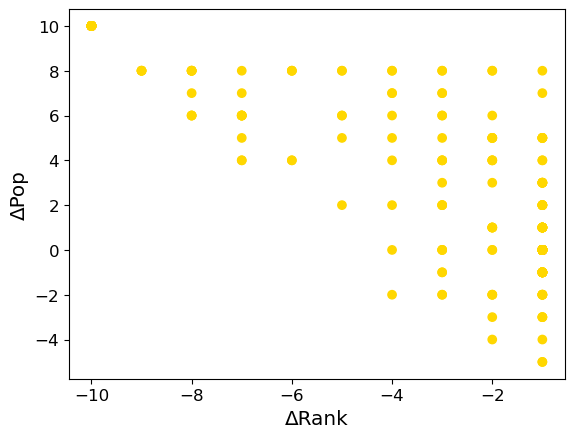

In [50]:
d_pop, d_rank, color = [], [], []
out_path = "./docking_poses/DynBind/self_cross_dock/"

df_dyn = df_dyn.loc[df_dyn.PDB_chain.isin(ro_ts_pca.PDB_chain)].reset_index(drop=True)
df_dyn_crd = df_dyn[~df_dyn.PDB_chain_LIG.isin(sd_cdk2.PDB_chain_LIG)]
    
for pdb_chain, lig, lo_label in zip(df_dyn_crd.drop_duplicates(["PDB_chain_LIG"]).PDB_chain, \
                                    df_dyn_crd.drop_duplicates(["PDB_chain_LIG"]).LIG, \
                                    df_dyn_crd.drop_duplicates(["PDB_chain_LIG"]).lo_label):

    lig_fns = sorted(glob(f'{out_path}/{pdb_chain}-{lig}/rank*_*.sdf'), \
                     key=lambda x: int(os.path.basename(x).strip('.sdf').split('/')[-1].split('_')[0].strip("rank")))
    # lig_fns = sorted(glob(f'{out_path}/{name}_*.pdb'), \
    #                  key=lambda x: -float(os.path.basename(x).strip('.pdb').split('/')[-1].split('_')[4]))
    name = f"{pdb_chain}_{lig}"
    cent_dist = df_dyn_crd[df_dyn_crd.PDB_chain_LIG==name].centroid_distance.to_list()

    if any([x < 5.0 for x in cent_dist]):
        r, p = get_crossdocking_bias(lig_fns, df_dyn_crd[df_dyn_crd.PDB_chain_LIG==name], cent_dist, lt=5)
        d_pop.append(p)
        d_rank.append(r)
        color.append(lo_label)

color_list = ['gold', 'pink']
plt.scatter(d_rank, d_pop, color = [color_list[x] for x in color])
plt.xlabel(f"ΔRank")
plt.ylabel(f"ΔPop")